In [3]:
%run ../Python/PageHD1.py
%matplotlib notebook
import scipy.sparse

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def pop_f(R, tuning, weights, f):
    return np.inner(R.T, weights@f(tuning))

def compute_HD(R, tuning, weights=None):
    if weights is None:
        weights = np.identity(tuning.size)
    HD_sin = pop_f(R, tuning, weights, np.sin)
    HD_cos = pop_f(R, tuning, weights, np.cos)
    HD = np.arctan(HD_sin / HD_cos)
    HD[HD_cos < 0] += np.pi
    HD[(HD_sin < 0) & (HD_cos > 0)] += 2*np.pi
    return HD

def read_map(prefix, with_distal=True):
    import csv
    proximal_objs = []
    distal_objs = None
    with open(prefix + '/Agent/map.info', newline='\n') as csvfile:
        mapreader = csv.reader(csvfile, delimiter=',')
        i = 0
        for row in mapreader:
            if i == 0:
                bound_x, bound_y = row
                bound_x, bound_y = float(bound_x), float(bound_y)
            elif with_distal and i == 1:
                distal_objs = np.array(row, dtype=float)
            else:
                proximal_objs.append(list(row))
            i += 1
    return (bound_x, bound_y), distal_objs, np.array(proximal_objs, dtype=float)


# Below are from https://gist.github.com/pv/8036995

def edge_project(pts, fd, h0=1.0):
    """
    project points back on the boundary (where fd=0) using numerical gradient

    note : you should specify h0 according to your actual mesh size
    """
    deps = sqrt(np.finfo(float).eps)*h0
    d = fd(pts)
    dgradx = (fd(pts + [deps, 0]) - d) / deps
    dgrady = (fd(pts + [0, deps]) - d) / deps
    dgrad2 = dgradx**2 + dgrady**2
    dgrad2[dgrad2 == 0] = 1.
    # calculate gradient vector (minus)
    pgrad = np.vstack([d*dgradx/dgrad2, d*dgrady/dgrad2]).T
    return pgrad

from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, rate_map, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    rates = []
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        rates.append(rate_map[tuple(vor.points[p1].tolist())])
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        try:
            ridges = all_ridges[p1]
        except KeyError:
            rates = rates[:-1]
            continue
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())
        
    return new_regions, np.asarray(new_vertices), rates

In [4]:
cd ../Build

/home/toby/src/oftnai/Spike-experiments/Build


In [5]:
#outdir = 'pandapics/HD_VIS_out' #_no_PLACE_20170925'
#outdir = 'pandapics/PLACE_out_no_HD'
outdir = 'pandapics/PLACE_detour'
rate_buf_ival = 2**-4
weights_buf_ival = 120.0

bounds, distal_objects, proximal_objects = read_map(outdir, with_distal=False)
bound_x = bounds[0]
bound_y = bounds[1]
print(bounds)

num_objects = proximal_objects.shape[0] # + distal_objects.shape[0]
print(proximal_objects)
#print(distal_objects)

N_VIS = num_objects * 60
#N_VIS2 = 500
N_HD = 300
N_FV = 2 * 50
N_FVxHD = 2 * N_HD
N_PLACE = 400
N_PLACExFVxHD = 2 * N_PLACE
N_GRID = 20

(15.0, 22.0)
[[ 2. 22.]
 [ 0. 19.]
 [ 9. 19.]
 [14. 18.]
 [ 7. 15.]
 [ 0. 14.]
 [14. 14.]
 [ 4. 12.]
 [10. 12.]
 [ 0. 10.]
 [14. 10.]
 [ 7.  9.]
 [14.  6.]
 [ 0.  5.]
 [ 9.  5.]
 [ 2.  1.]]


/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


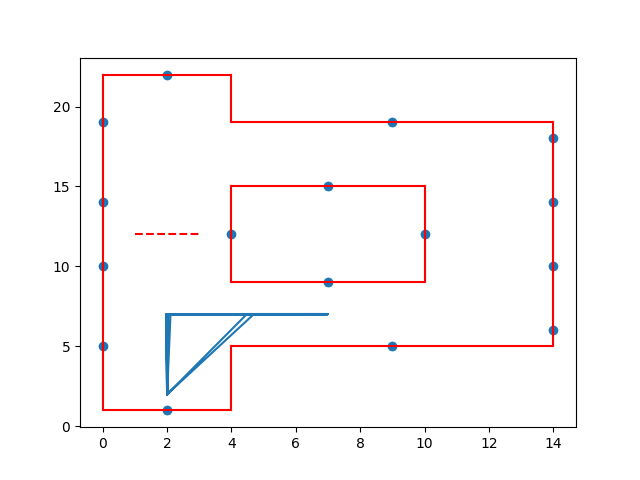

<IPython.core.display.Javascript object>


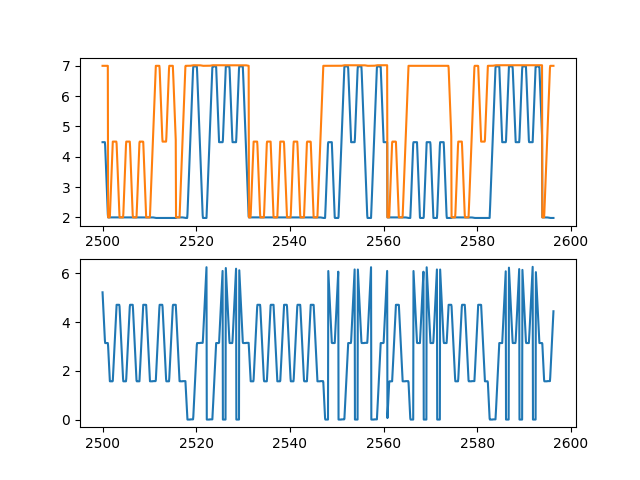

<IPython.core.display.Javascript object>


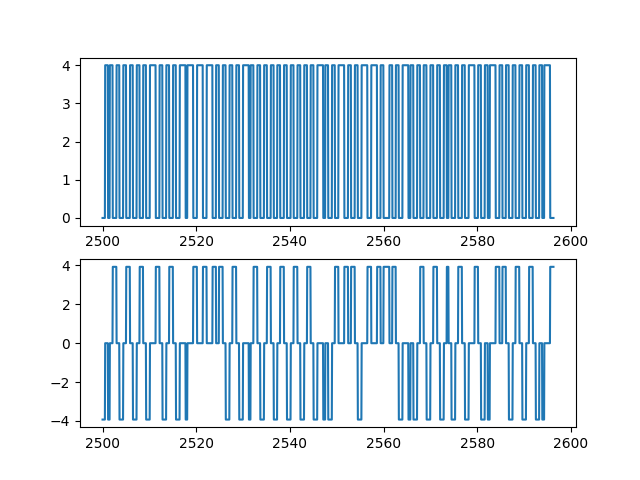

In [200]:
test_start_t = 2500 # 18497.5 # 31124.5 # 1915 # 101 # 1017 # 355
test_stop_t = test_start_t + 1200 # 1022
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)

agent_hist = read_rates(outdir, 'Agent', 6, fname='history.bin')[:, test_start_i:test_stop_i]
T = agent_hist[5]

fig, ax = plt.subplots()
#ax.set_xlim(0, bound_x)
#ax.set_ylim(0, bound_y)
try: ax.scatter(proximal_objects[:, 0], proximal_objects[:, 1])
except IndexError: pass
ax.plot(agent_hist[0], agent_hist[1])
ax.plot()

# Plot barriers:
opaque_barriers = np.loadtxt(outdir + '/Agent/opaque_barriers_xy.info.new', delimiter=',')
for b in opaque_barriers:
    ax.plot(np.linspace(b[0], b[2]), np.linspace(b[1], b[3]), '-r')
clear_barriers = np.loadtxt(outdir + '/Agent/clear_barriers_xy.info.new', delimiter=',')
for b in clear_barriers.reshape((int(len(clear_barriers)/4), 4)):
    ax.plot(np.linspace(b[0], b[2]), np.linspace(b[1], b[3]), '--r')

fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(T, agent_hist[0])
ax[0].plot(T, agent_hist[1])
ax[1].plot(T, agent_hist[2])
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(T, agent_hist[3])
ax[1].plot(T, agent_hist[4])

cell 8 has r_max 0.301885


/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/ipykernel_launcher.py:43: UserWarning: loadtxt: Empty input file: "pandapics/PLACE_detour/Agent/clear_barriers_xy.info"
/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


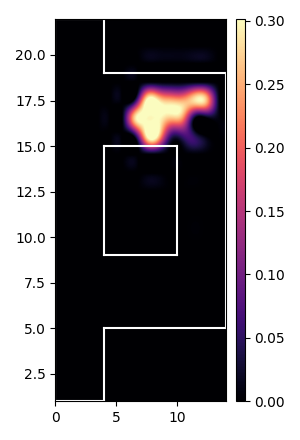

cell 34 has r_max 0.348207


<IPython.core.display.Javascript object>


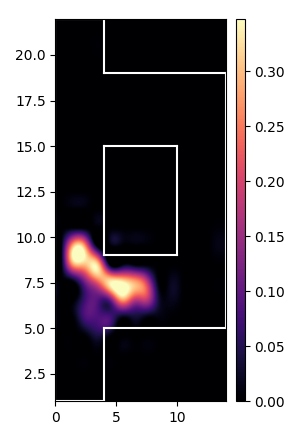

cell 58 has r_max 0.326724


<IPython.core.display.Javascript object>


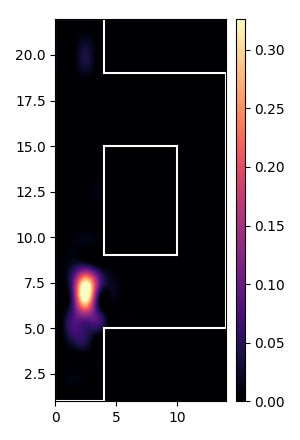

cell 68 has r_max 0.290233


<IPython.core.display.Javascript object>


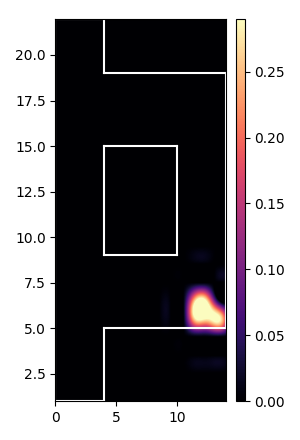

cell 84 has r_max 0.357562


<IPython.core.display.Javascript object>


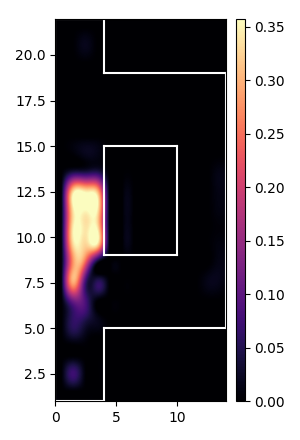

cell 89 has r_max 0.314265


<IPython.core.display.Javascript object>


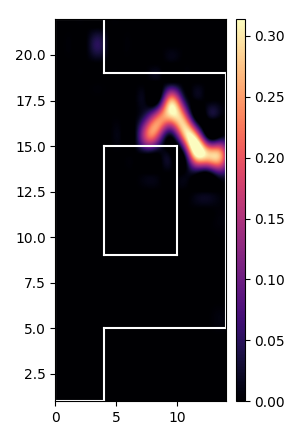

cell 115 has r_max 0.367257


<IPython.core.display.Javascript object>


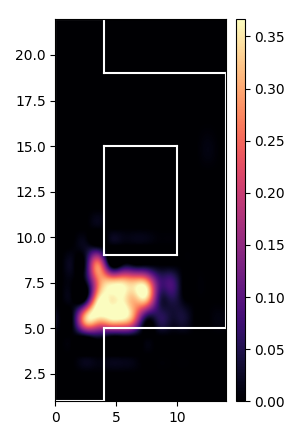

cell 214 has r_max 0.352668


<IPython.core.display.Javascript object>


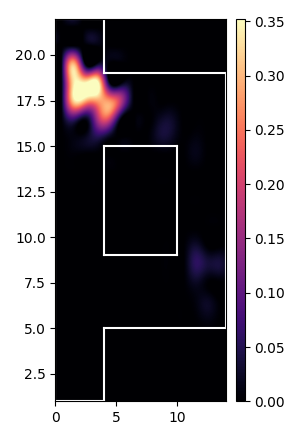

cell 280 has r_max 0.338525


<IPython.core.display.Javascript object>


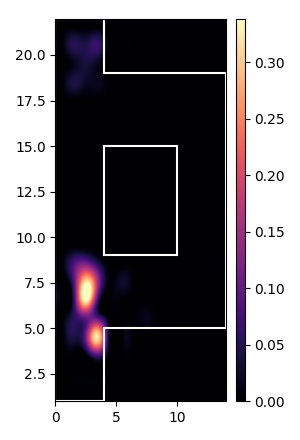

cell 377 has r_max 0.345373


<IPython.core.display.Javascript object>


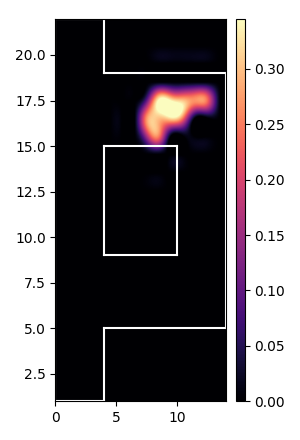

cell 388 has r_max 0.284987


<IPython.core.display.Javascript object>


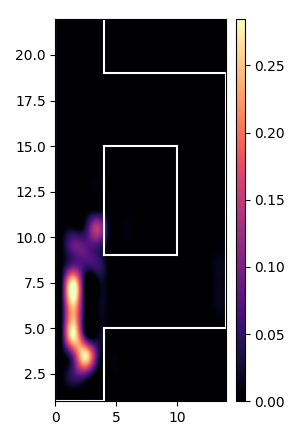

In [132]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def bin_rates(bound_x, bound_y, width_x, width_y, agent_hist, R):
    X, Y, T = agent_hist[0], agent_hist[1], agent_hist[5]

    rates_field = np.zeros((R.shape[0], int(bound_y//width_y), int(bound_x//width_x)), dtype=float)
    times_field = np.zeros((int(bound_y//width_y), int(bound_x//width_x)), dtype=float)

    for s in range(len(T)-1):
        bin_x = width_x * (X[s] // width_x)
        bin_y = width_y * (Y[s] // width_y)
        i = int((bound_y - bin_y) // width_y)
        j = int(bin_x // width_x)
        t = T[s+1]-T[s]
        rates_field[:,i,j] += R[:, s]*t
        times_field[i,j] += t

    rates_field /= times_field
    rates_field[np.isnan(rates_field)] = 0

    return rates_field


test_start_t = 1630 #  450 1630 2810 3990 5170 6350
test_stop_t = test_start_t + 580 # 1022
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)

width_x = 1.0
width_y = 1.0

r_thresh = 0.2

cells_type = 'PLACE'
cells_N = N_PLACE

agent_hist = read_rates(outdir, 'Agent', 6, fname='history.bin')[:, test_start_i:test_stop_i]
R = read_rates(outdir, cells_type, cells_N)[:, test_start_i:test_stop_i]

data = bin_rates(bound_x, bound_y, width_x, width_y, agent_hist, R) #, r_thresh)

opaque_barriers = np.loadtxt(outdir + '/Agent/opaque_barriers_xy.info', delimiter=',')
clear_barriers = np.loadtxt(outdir + '/Agent/clear_barriers_xy.info', delimiter=',')
#print(barriers)
x_min = min(np.min(opaque_barriers[:,0]), np.min(opaque_barriers[:,2]))
x_max = max(np.max(opaque_barriers[:,0]), np.max(opaque_barriers[:,2]))
y_min = min(np.min(opaque_barriers[:,1]), np.min(opaque_barriers[:,3]))
y_max = max(np.max(opaque_barriers[:,1]), np.max(opaque_barriers[:,3]))

# [8, 34, 58, 68, 84, 89, 115, 185, 296, 214, 280, 314, 377, 388]
for cell in [8, 34, 58, 68, 84, 89, 115, 185, 296, 214, 280, 314, 377, 388]: # range(cells_N):
    r_max = np.max(data[cell])
    if (r_max > r_thresh):
        print('cell %d has r_max %f' % (cell, r_max))
        fig, ax = plt.subplots(figsize=(bound_x/5.0, bound_y/5.0), tight_layout=True)
        im = ax.imshow(data[cell], interpolation='lanczos', aspect='auto',
                       extent=(0, bound_x, 0, bound_y), cmap=plt.get_cmap('magma'))

        ax.autoscale(False)
        for b in opaque_barriers:
            ax.plot(np.linspace(b[0], b[2]), np.linspace(b[1], b[3]), '-w')
        for b in clear_barriers.reshape((int(len(clear_barriers)/4), 4)):
            ax.plot(np.linspace(b[0], b[2]), np.linspace(b[1], b[3]), '--w')
        
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax, orientation='vertical')

    else:
        #print('ignoring %d with r_max %f' % (cell, r_max))
        continue

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


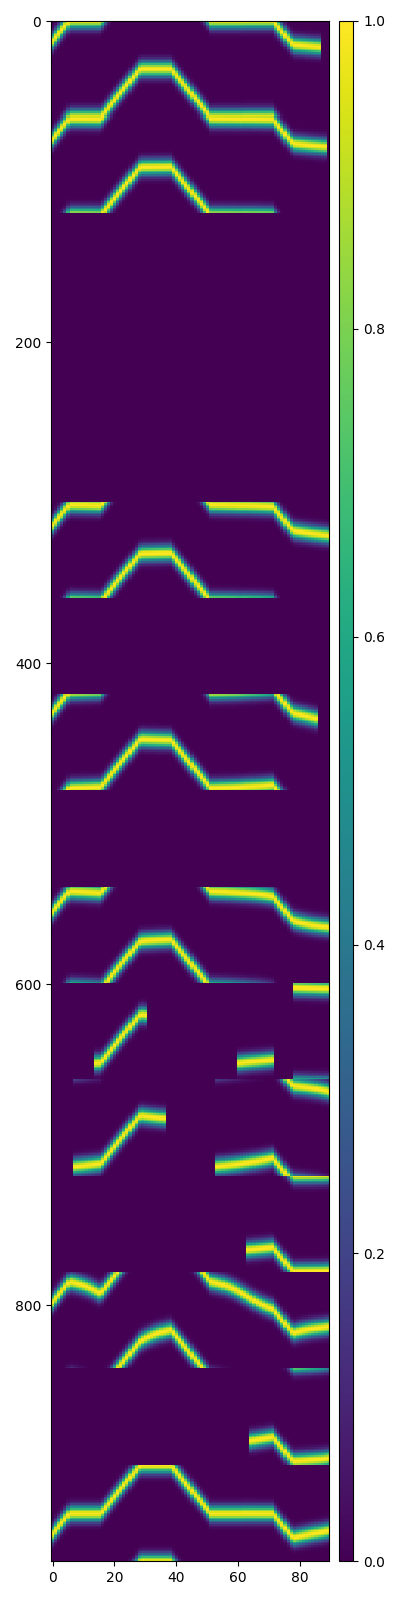

Sparsity: 0.075721


In [203]:
R_VIS = read_rates(outdir, 'VIS', N_VIS)
imshow(R_VIS[:, -2000:]) #test_start_i:test_stop_i])
print('Sparsity: %f' % (np.mean(np.sum(R_VIS, 0)) / N_VIS))

<IPython.core.display.Javascript object>


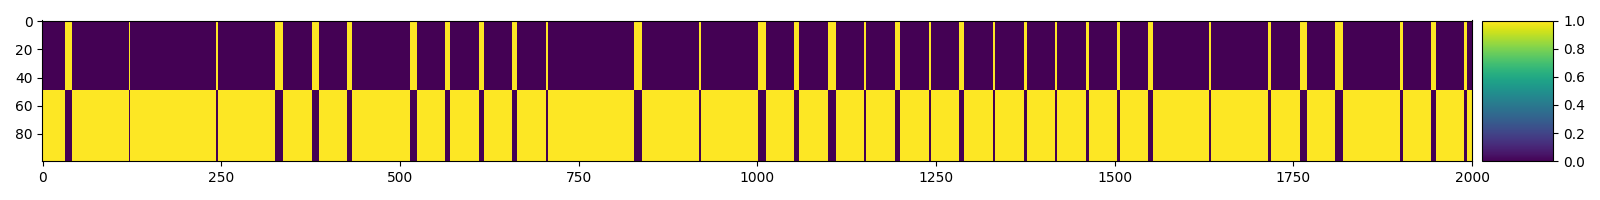

Sparsity: 0.500000


In [127]:
R_FV = read_rates(outdir, 'FV', N_FV)
imshow(R_FV[:, -2000:])
print('Sparsity: %f' % (np.mean(np.sum(R_FV, 0)) / N_FV))

<IPython.core.display.Javascript object>


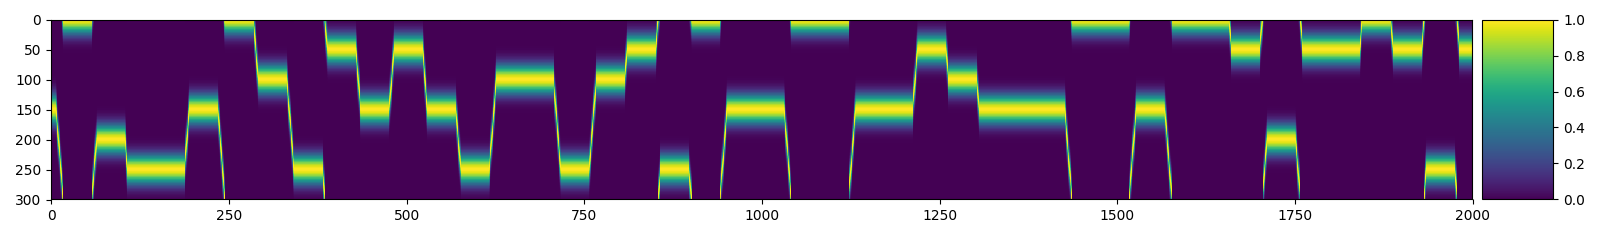

Sparsity: 0.127644


In [137]:
R_HD = read_rates(outdir, 'HD', N_HD)
imshow(R_HD[:, -2000:])
print('Sparsity: %f' % (np.mean(np.sum(R_HD, 0)) / N_HD))

<IPython.core.display.Javascript object>


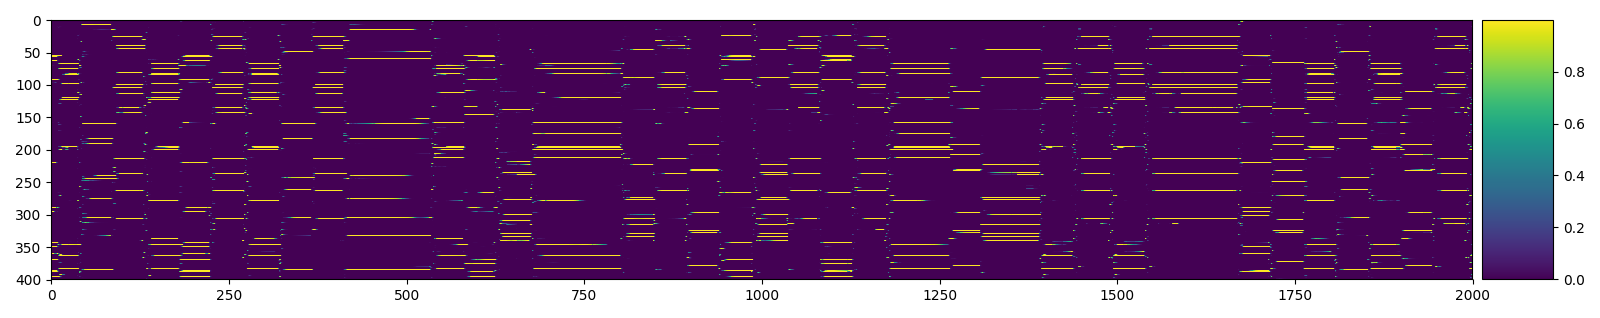

Sparsity: 0.035863


In [178]:
R_PLACE = read_rates(outdir, 'PLACE', N_PLACE)
imshow(R_PLACE[:, -2000:])
print('Sparsity: %f' % (np.mean(np.sum(R_PLACE, 0)) / N_PLACE))

<IPython.core.display.Javascript object>


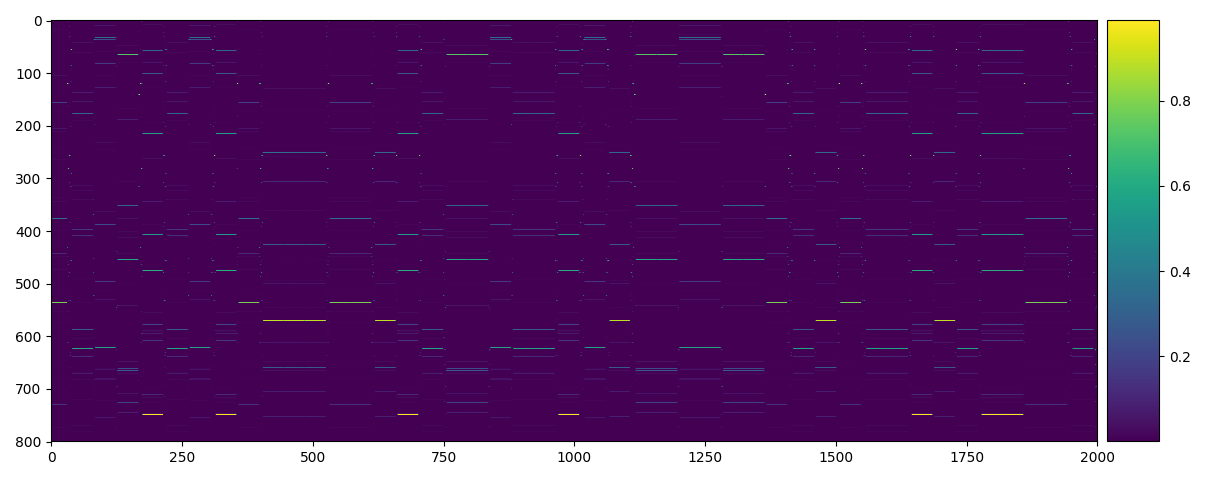

Sparsity: 0.005769


In [134]:
R_PLACExFVxHD = read_rates(outdir, 'PLACExFVxHD', N_PLACExFVxHD)
imshow(R_PLACExFVxHD[:, -2000:])
print('Sparsity: %f' % (np.mean(np.sum(R_PLACExFVxHD, 0)) / N_PLACExFVxHD))

(300, 644) 6400 26112 0.015625
[[ 37  42  50]
 [250 131  51]
 [ 49 256  52]]


<IPython.core.display.Javascript object>


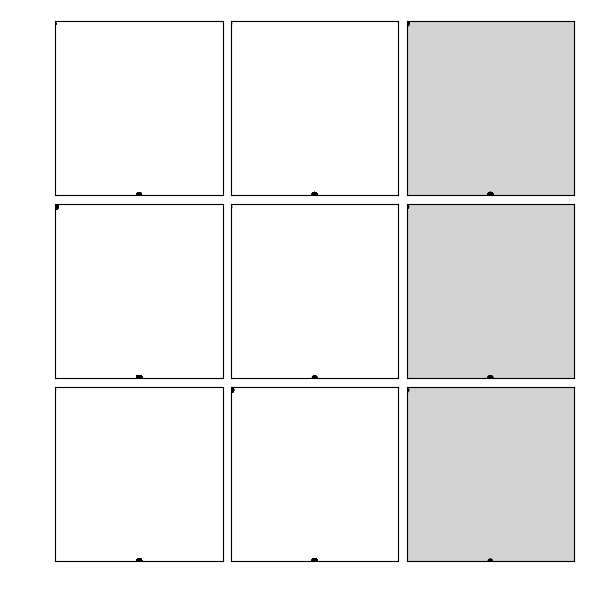

In [645]:
bound_x_grid, bound_y_grid = 4.0, 4.0 # 0.6, 0.6
test_start_t = 100 # 6600
test_stop_t = test_start_t + 308 # 300
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
start, stop = test_start_i, test_stop_i # -10000, -1
#start, stop = -10000, -1
step = 5
agent_hist = read_rates(outdir, 'Agent', 3, fname='history.bin')
X, Y = agent_hist[0][start:stop:step], agent_hist[1][start:stop:step]
R = read_rates(outdir, 'HD', N_HD)[:, start:stop:step].copy()
#R = read_rates(outdir, 'GRID', N_GRID)[:, start:stop:step].copy()
#R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop:step].copy()
R_max_early = np.max(read_rates(outdir, 'HD', N_HD)[:, :stop-start:step])
print(R.shape, start, stop, rate_buf_ival)
#J = np.array([[72, 32],[34, 44]])
Jshape = np.array((3, 3))
J = np.random.choice(np.arange(R.shape[0]), np.prod(Jshape), replace=False).reshape(Jshape)
# 77, 49, 80, 49, 72, 66, 73, 70
####J = np.array([[119, 113, 179],[145, 106, 139],[155, 166, 50]]) # 166, 7, 70, 22; 199
####J = np.array([[119, 145, 52],[113, 106, 51],[155, 166, 50]]) # 166, 7, 70, 22; 199
J[:, 2] = [50, 51, 52]
J = np.array([[37, 42, 50], [250, 131, 51], [49, 256, 52]])
R[50] = read_rates(outdir, 'HD', N_HD)[J[1,0], :R.shape[1]*step:step].copy() / R_max_early
R[51] = read_rates(outdir, 'HD', N_HD)[J[1,1], :R.shape[1]*step:step].copy() / R_max_early
R[52] = read_rates(outdir, 'HD', N_HD)[J[1,2], :R.shape[1]*step:step].copy() / R_max_early
R_max = np.max(R)
print(J)
fig, ax = plt.subplots(*(J.shape), figsize=2*Jshape)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
ax_flat = ax.flatten()
for i, j in enumerate(J.flatten()):
    C = np.zeros((len(R[j]), 4))
    R_j = R[j]/R_max
    R_j[R_j<0] = 0 # occasionally there are tiny negative values ...
    C[:, 3] = R_j
    #R_j[R_FV[0,:len(R_j)]>0] = 0 # remove points without forward motion
    ax_flat[i].scatter(X, Y, 12*R_j, C, cmap=plt.get_cmap('binary'))
    ax_flat[i].set_xlim(0, bound_x_grid)
    ax_flat[i].set_ylim(0, bound_y_grid)
    ax_flat[i].tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
for a in ax[:, J.shape[1]-1]:
    a.set_facecolor('lightgray')
fig.patch.set_alpha(0.)
fig.savefig('not-place.png', edgecolor='none', dpi=300) # facecolor=fig.get_facecolor()

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


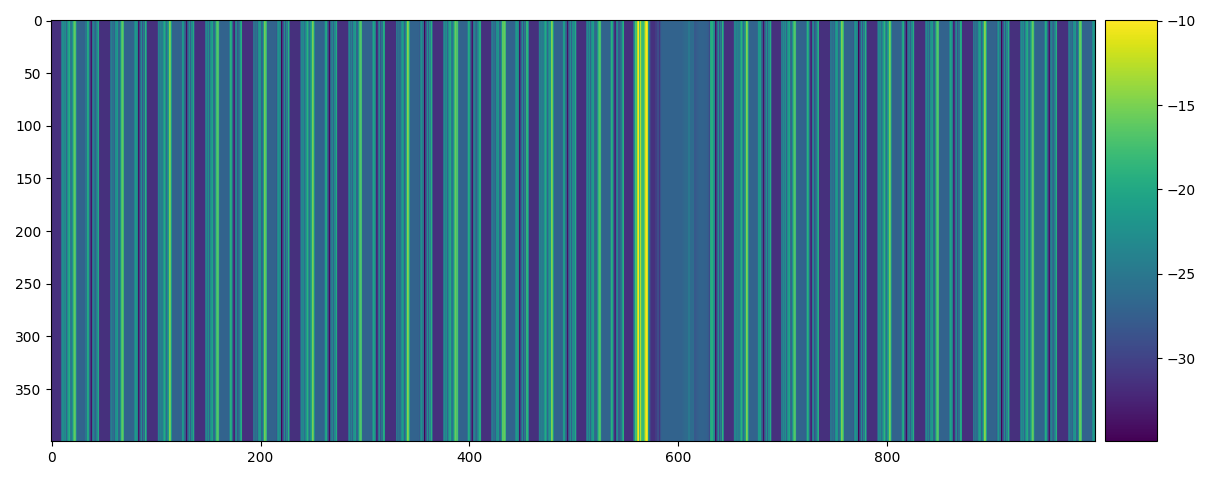

<IPython.core.display.Javascript object>


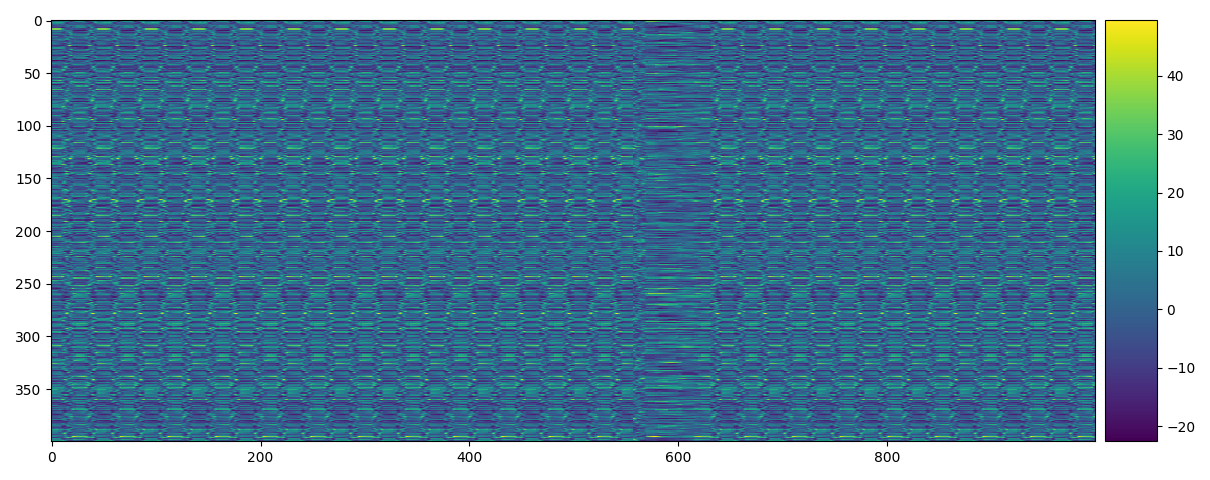

<IPython.core.display.Javascript object>


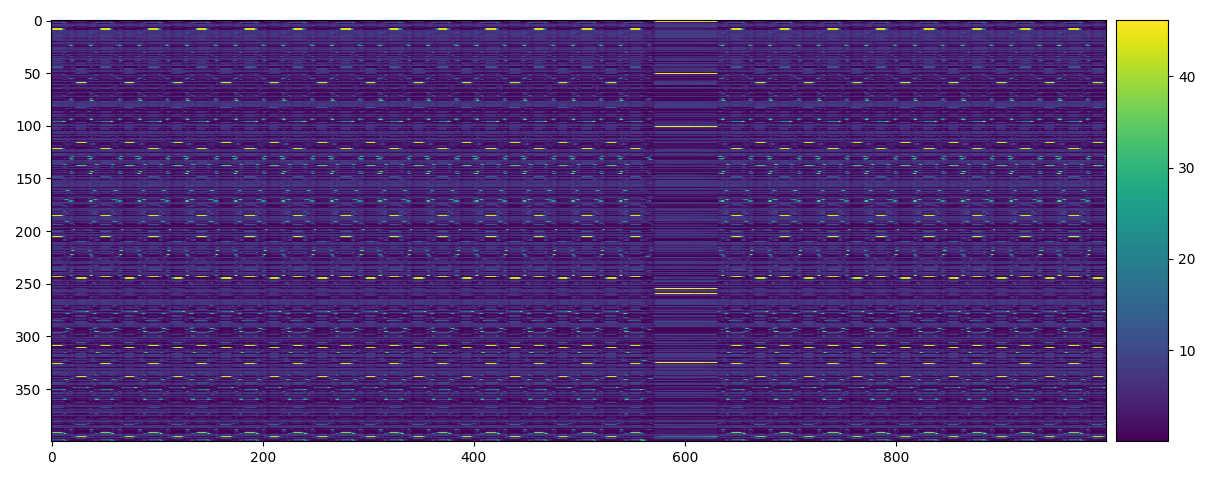

<IPython.core.display.Javascript object>


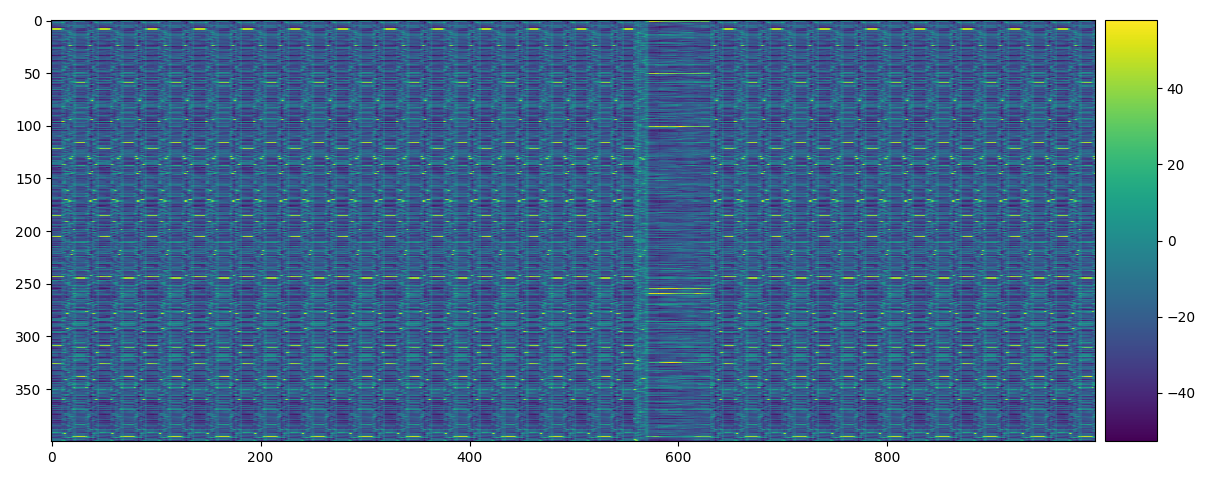

<IPython.core.display.Javascript object>


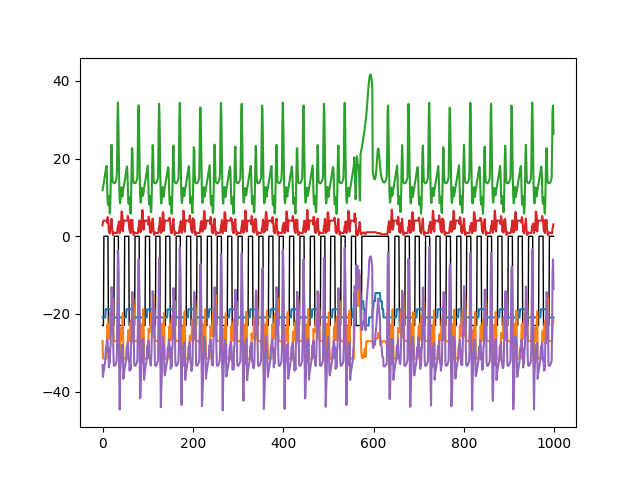

<IPython.core.display.Javascript object>


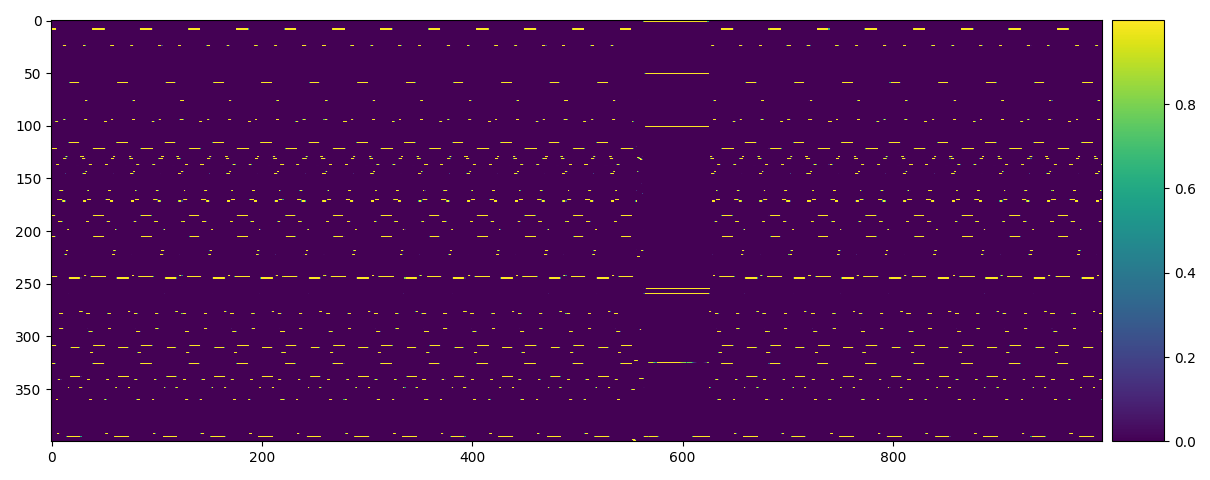

<IPython.core.display.Javascript object>


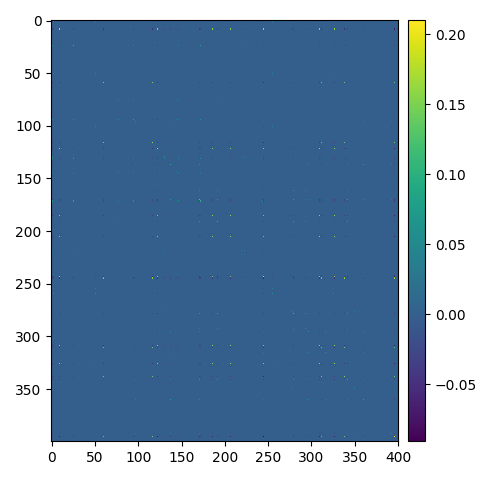

<IPython.core.display.Javascript object>


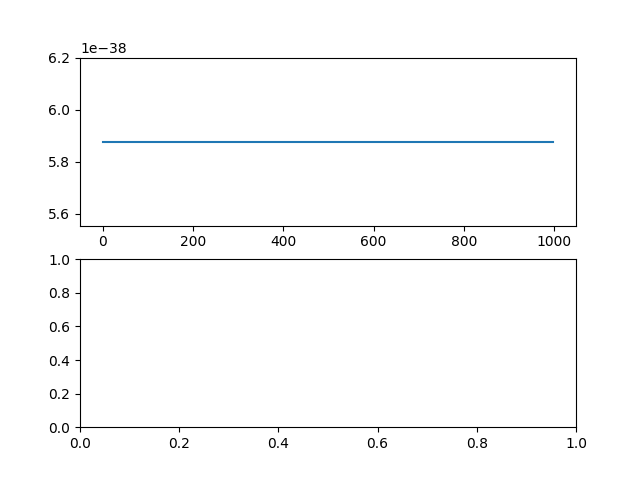

-25.943445 -19.958101 21.657963 5.1273613
Sparsity: 0.014402


In [130]:
#start, stop = test_start_i, test_stop_i
start, stop = -1000, -1
#start, stop = test_start_i, test_start_i+1000

R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]
R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop]
H_VIS_PLACE_INH = accumulate_activation(outdir, 'PLACE', ['VIS'], N_PLACE, slice(start, stop), INH=True)
H_PLACE_PLACE_INH = accumulate_activation(outdir, 'PLACE', ['PLACE'], N_PLACE, slice(start, stop), INH=True) # 'AHVxHD'
H_VIS_PLACE = accumulate_activation(outdir, 'PLACE', ['VIS'], N_PLACE, slice(start, stop))
H_PLACExFVxHD_PLACE = accumulate_activation(outdir, 'PLACE', ['PLACExFVxHD'], N_PLACE, slice(start, stop))
imshow(H_PLACE_PLACE_INH)
#imshow(H_VIS_PLACE_INH)
#imshow(H_VIS_PLACE)
imshow(H_VIS_PLACE+H_VIS_PLACE_INH)
imshow(H_PLACExFVxHD_PLACE)
imshow((H_VIS_PLACE_INH + H_PLACE_PLACE_INH + H_VIS_PLACE + H_PLACExFVxHD_PLACE)) #[W_VIS_PLACE_idx])

fig, ax = plt.subplots()
# blue, orange, green, red, purple
j = 40
ax.plot(R_FV[0]*np.min(H_VIS_PLACE_INH), color='black', lw=1)
ax.plot(H_VIS_PLACE_INH[j])
ax.plot(H_PLACE_PLACE_INH[j])
ax.plot(H_VIS_PLACE[j])
ax.plot(H_PLACExFVxHD_PLACE[j])
ax.plot(H_VIS_PLACE_INH[j] + H_PLACE_PLACE_INH[j] + H_VIS_PLACE[j] + H_PLACExFVxHD_PLACE[j])

R_PLACE = read_rates(outdir, 'PLACE', N_PLACE)[:, start:stop]
imshow(R_PLACE) # [W_VIS_HD_idx])
imshow(np.cov(R_PLACE)) # [W_VIS_HD_idx]))
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(R_PLACE[40])
#ax[0].plot(R_HD[W_VIS_HD_idx[-10]])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -1])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -21])
#ax[1].plot(R_HD[W_VIS_HD_idx][:, -41])

print(np.mean(H_PLACE_PLACE_INH), np.mean(H_VIS_PLACE_INH), np.mean(H_VIS_PLACE), np.mean(H_PLACExFVxHD_PLACE))
print('Sparsity: %f' % (np.mean(R_PLACE)))
#print(np.mean(read_rates(outdir, 'HD', N_HD), 0))

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


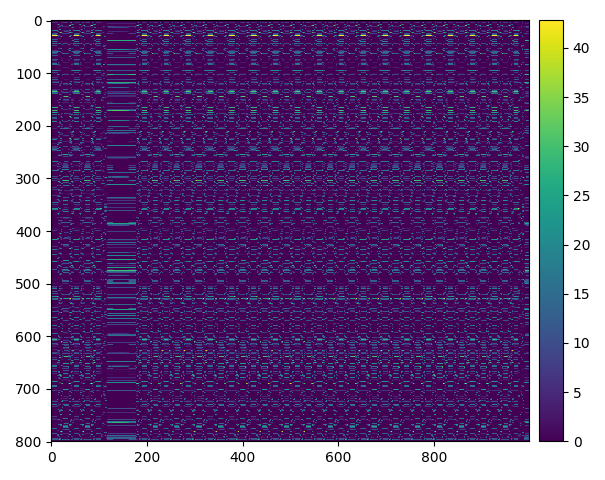

<IPython.core.display.Javascript object>


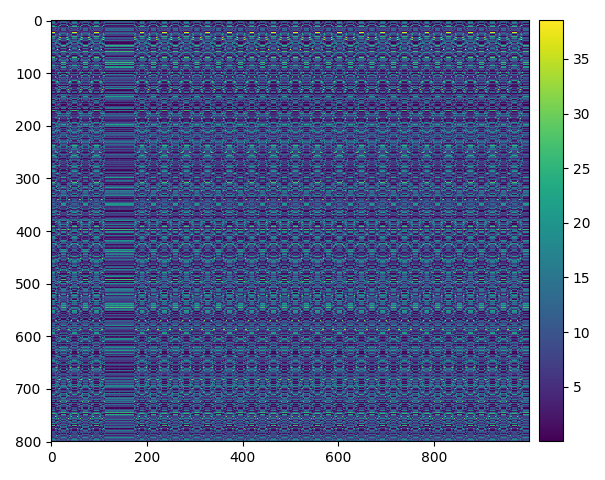

<IPython.core.display.Javascript object>


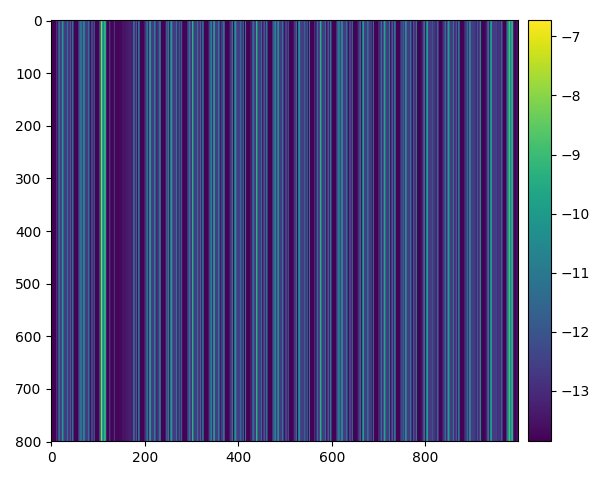

<IPython.core.display.Javascript object>


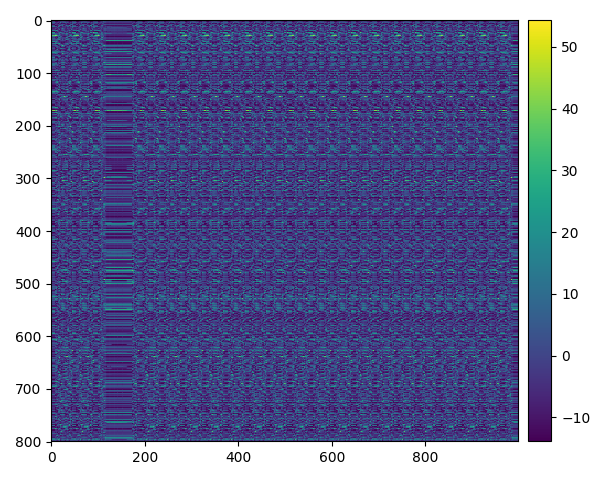

<IPython.core.display.Javascript object>


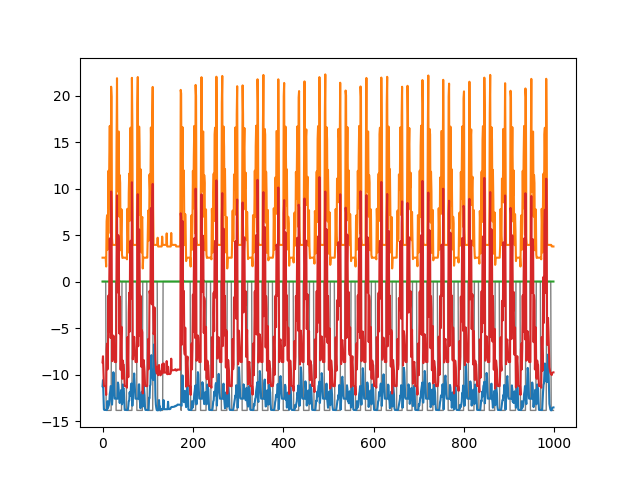

<IPython.core.display.Javascript object>


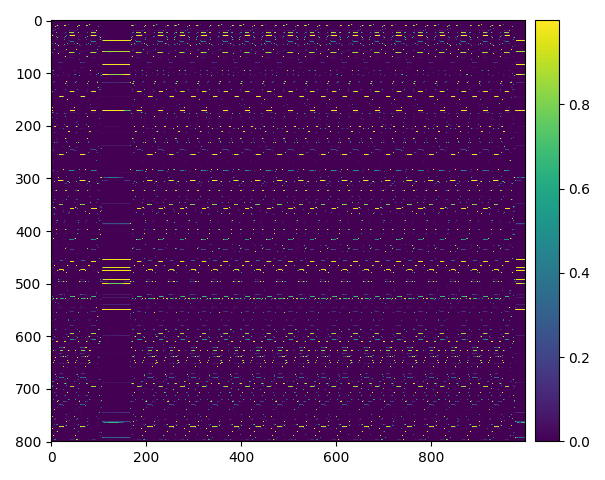

<IPython.core.display.Javascript object>


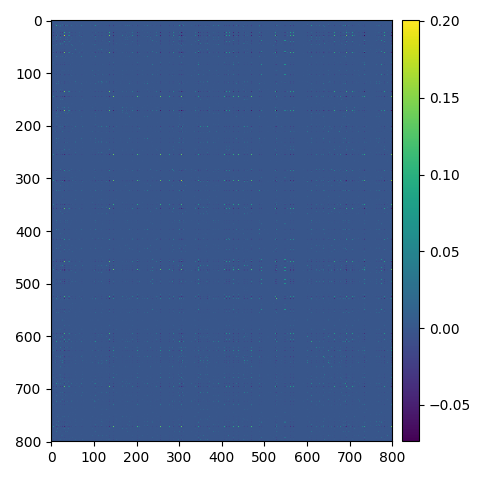

<IPython.core.display.Javascript object>


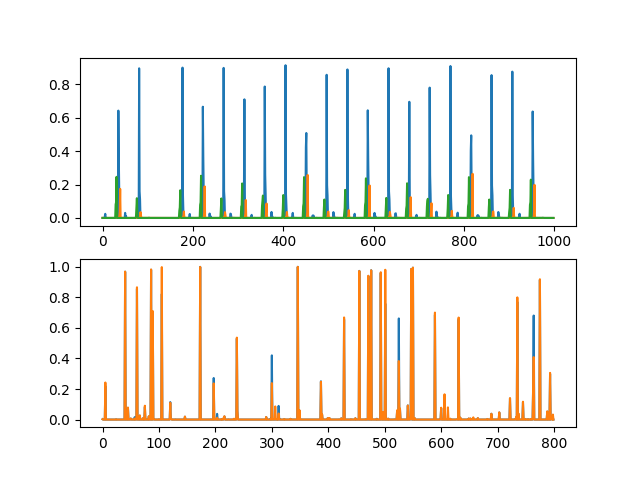

-12.4837 9.006894 2.7677143
Sparsity: 0.024981


In [129]:
start, stop = -1000, -1

R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop]
#R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]

H_PLACExFVxHD_INH = accumulate_activation(outdir, 'PLACExFVxHD', ['PLACExFVxHD'], N_PLACExFVxHD, slice(start, stop), INH=True) # 'HD'
H_PLACE_PLACExFVxHD = accumulate_activation(outdir, 'PLACExFVxHD', ['PLACE'], N_PLACExFVxHD, slice(start, stop))
#H_FV_PLACExFVxHD = accumulate_activation(outdir, 'PLACExFVxHD', ['FV'], N_PLACExFVxHD, slice(start, stop))
#H_HD_PLACExFVxHD = accumulate_activation(outdir, 'PLACExFVxHD', ['HD'], N_PLACExFVxHD, slice(start, stop))
#H_FVxHD_PLACExFVxHD = H_FV_PLACExFVxHD + H_HD_PLACExFVxHD
H_FVxHD_PLACExFVxHD = accumulate_activation(outdir, 'PLACExFVxHD', ['FVxHD'], N_PLACExFVxHD, slice(start, stop))
H_PLACExFVxHD = H_PLACExFVxHD_INH + H_PLACE_PLACExFVxHD + H_FVxHD_PLACExFVxHD
imshow(H_PLACE_PLACExFVxHD)
imshow(H_FVxHD_PLACExFVxHD)
imshow(H_PLACExFVxHD_INH)
imshow(H_PLACExFVxHD) #[W_idx_s])

# blue, orange, green, red, purple
fig, ax = plt.subplots()
j = 193
ax.plot(R_FV[0]*np.min(H_PLACExFVxHD_INH[j]), color='gray', lw=1)
ax.plot(H_PLACExFVxHD_INH[j])
#ax.plot(H_FV_PLACExFVxHD[j])
#ax.plot(H_HD_PLACExFVxHD[j])
ax.plot(H_FVxHD_PLACExFVxHD[j])
ax.plot(H_PLACE_PLACExFVxHD[j])
ax.plot(H_PLACExFVxHD[j])

R_PLACExFVxHD = np.array(read_rates(outdir, 'PLACExFVxHD', N_PLACExFVxHD)[:, start:stop])
imshow(R_PLACExFVxHD) # [W_idx_s])
imshow(np.cov(R_PLACExFVxHD))
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(R_PLACExFVxHD[10])
ax[0].plot(R_PLACExFVxHD[250])
ax[0].plot(R_PLACExFVxHD[500])
ax[1].plot(R_PLACExFVxHD[:, -1])
ax[1].plot(R_PLACExFVxHD[:, -17])

print(np.mean(H_PLACExFVxHD_INH), np.mean(H_FVxHD_PLACExFVxHD), np.mean(H_PLACE_PLACExFVxHD)) # np.mean(H_FV_PLACExFVxHD), np.mean(H_HD_PLACExFVxHD
print('Sparsity: %f' % (np.mean(np.sum(R_PLACExFVxHD, 0)) / N_PLACExFVxHD))

<IPython.core.display.Javascript object>


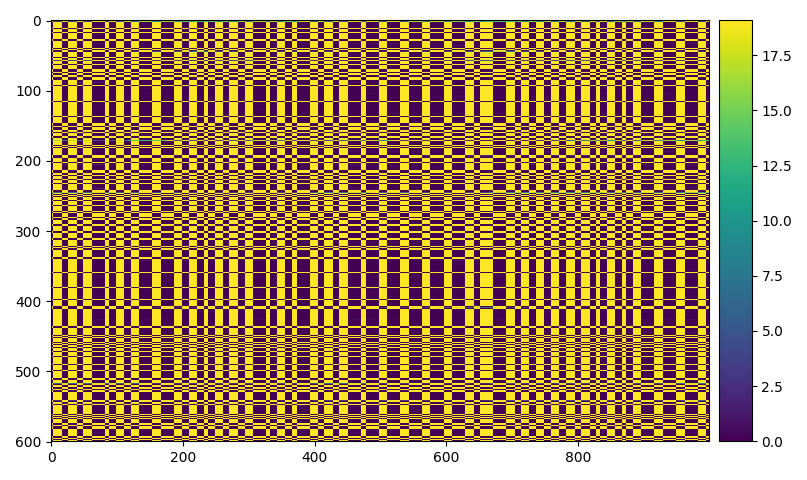

<IPython.core.display.Javascript object>


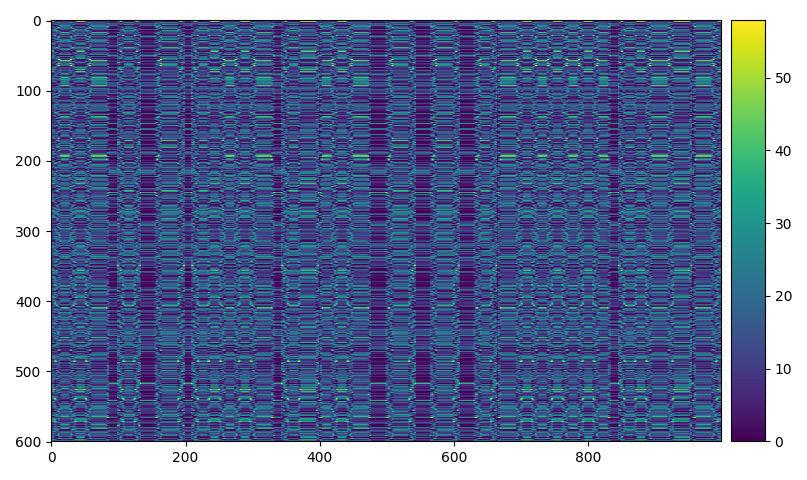

<IPython.core.display.Javascript object>


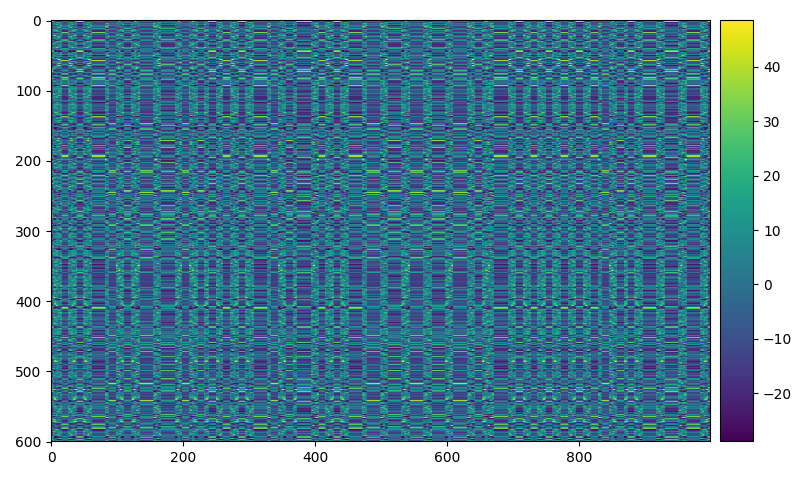

<IPython.core.display.Javascript object>


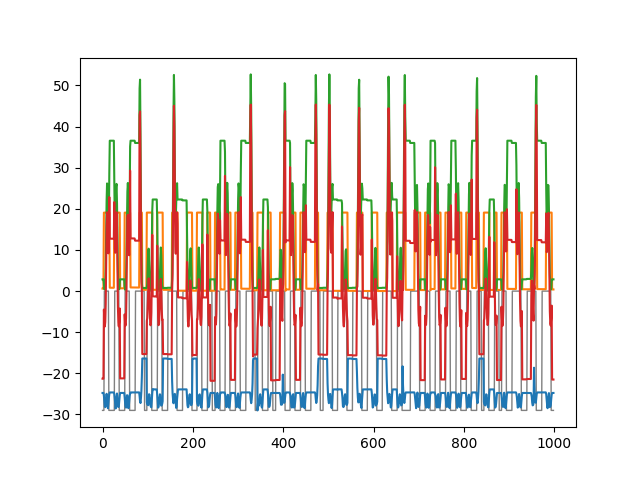

<IPython.core.display.Javascript object>


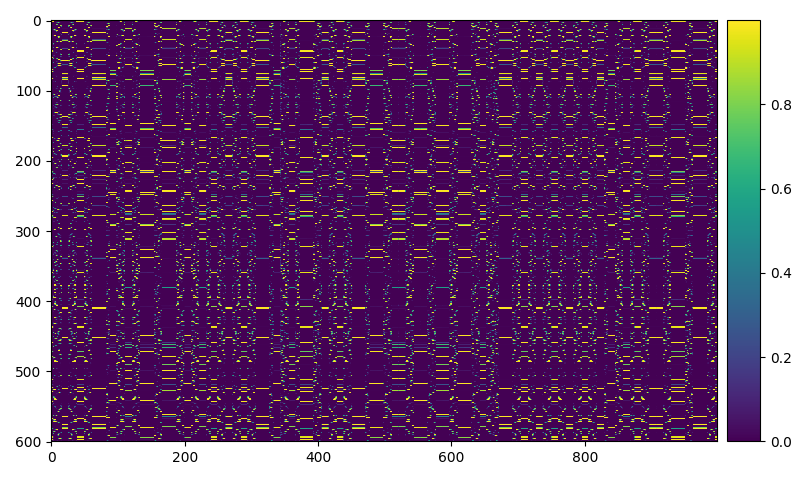

<IPython.core.display.Javascript object>


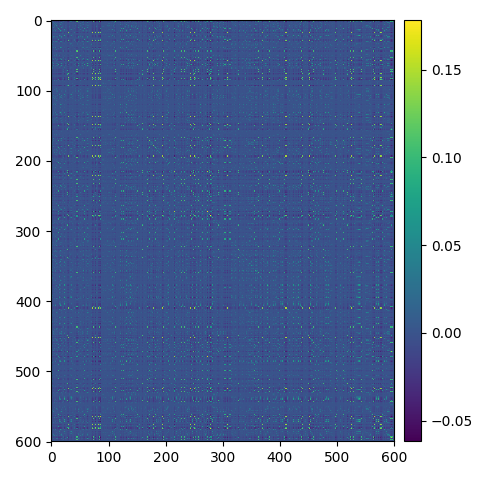

<IPython.core.display.Javascript object>


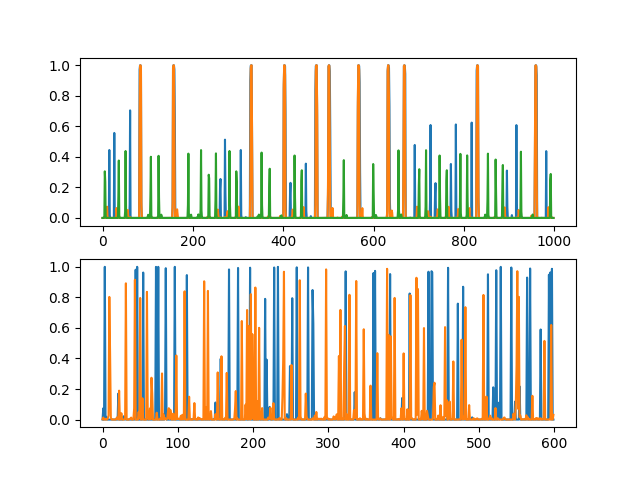

-24.452198 9.28052 13.927012
Sparsity: 0.067923


In [6]:
start, stop = -1000, -1

R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop]
R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]

H_FVxHD_INH = accumulate_activation(outdir, 'FVxHD', ['FVxHD'], N_FVxHD, slice(start, stop), INH=True) # 'HD'
H_FV_FVxHD = accumulate_activation(outdir, 'FVxHD', ['FV'], N_FVxHD, slice(start, stop))
H_HD_FVxHD = accumulate_activation(outdir, 'FVxHD', ['HD'], N_FVxHD, slice(start, stop))
H_FVxHD = H_FVxHD_INH + H_HD_FVxHD + H_FV_FVxHD
imshow(H_FV_FVxHD)
imshow(H_HD_FVxHD)
imshow(H_FVxHD) #[W_idx_s])

# blue, orange, green, red, purple
fig, ax = plt.subplots()
j = 199
ax.plot(R_FV[0]*np.min(H_FVxHD_INH[j]), color='gray', lw=1)
ax.plot(H_FVxHD_INH[j])
ax.plot(H_FV_FVxHD[j])
ax.plot(H_HD_FVxHD[j])
ax.plot(H_FVxHD[j])

R_FVxHD = np.array(read_rates(outdir, 'FVxHD', N_FVxHD)[:, start:stop])
imshow(R_FVxHD) # [W_idx_s])
imshow(np.cov(R_FVxHD))
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(R_FVxHD[10])
ax[0].plot(R_FVxHD[250])
ax[0].plot(R_FVxHD[500])
ax[1].plot(R_FVxHD[:, -1])
ax[1].plot(R_FVxHD[:, -17])

print(np.mean(H_FVxHD_INH), np.mean(H_FV_FVxHD), np.mean(H_HD_FVxHD))
print('Sparsity: %f' % (np.mean(np.sum(R_FVxHD, 0)) / N_FVxHD))

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


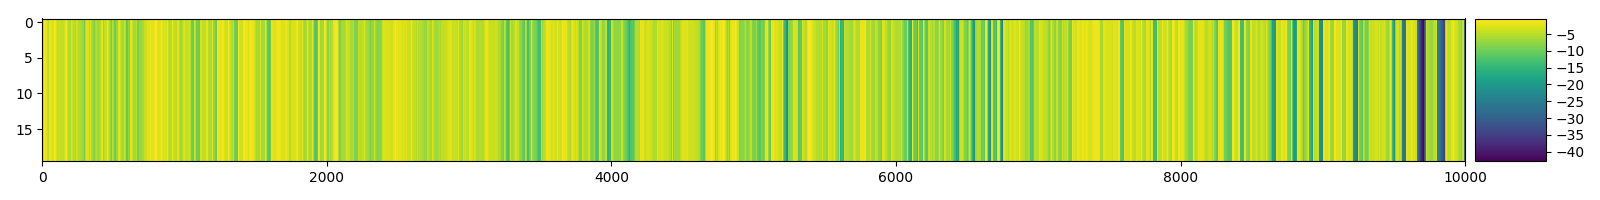

<IPython.core.display.Javascript object>


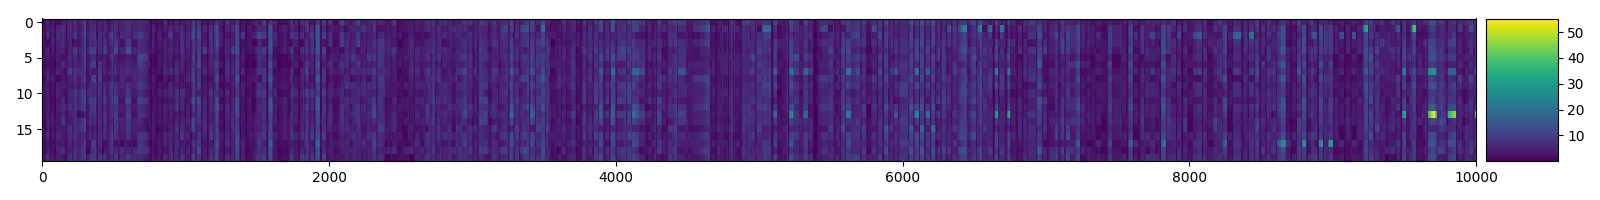

<IPython.core.display.Javascript object>


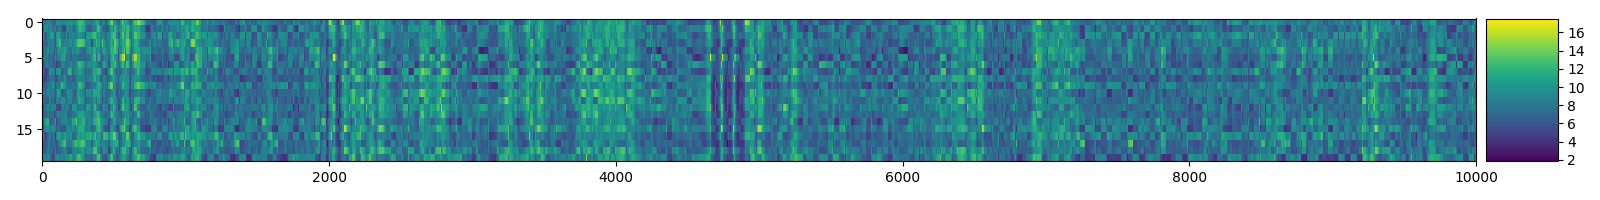

<IPython.core.display.Javascript object>


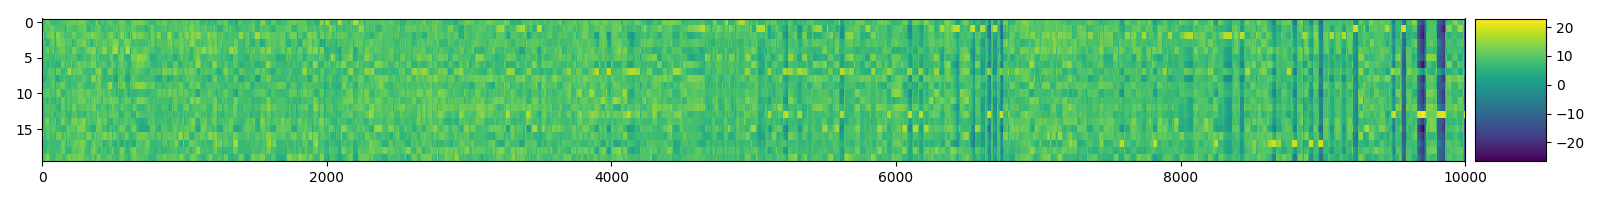

<IPython.core.display.Javascript object>


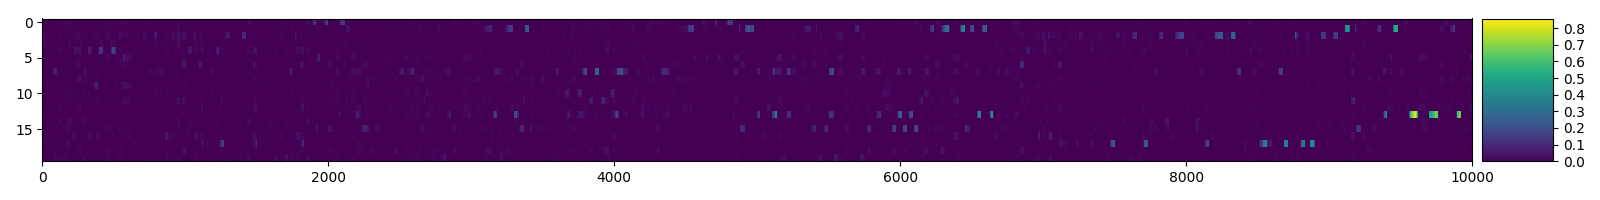

<IPython.core.display.Javascript object>


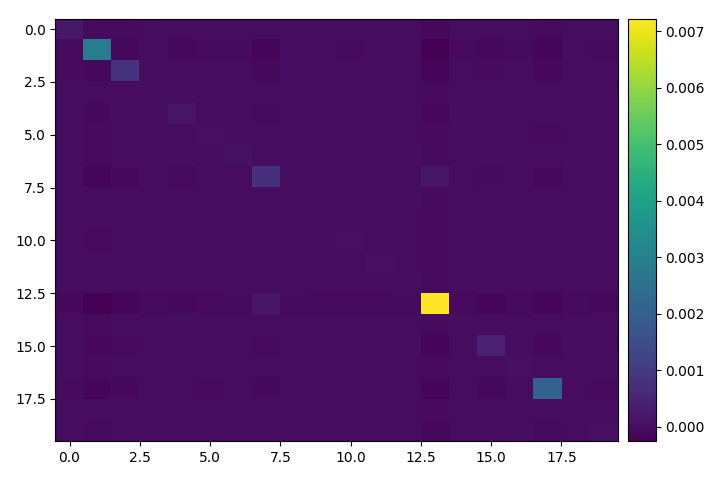

-5.71629 5.76593 8.33018
Sparsity: 0.005800


In [968]:
start, stop = test_start_i, test_stop_i
start, stop = -10000, -1
#start, stop = test_start_i, test_start_i+1000

R_HD = read_rates(outdir, 'HD', N_HD)[:, start:stop]
R_FV = read_rates(outdir, 'FV', N_FV)[:, start:stop]
H_GRID_GRID_INH = accumulate_activation(outdir, 'GRID', ['GRID'], N_GRID, slice(start, stop), INH=True) # 'AHVxHD'
H_PLACE_GRID = accumulate_activation(outdir, 'GRID', ['PLACE'], N_GRID, slice(start, stop))
H_VIS_GRID = accumulate_activation(outdir, 'GRID', ['VIS'], N_GRID, slice(start, stop))
imshow(H_GRID_GRID_INH)
imshow(H_PLACE_GRID)
imshow(H_VIS_GRID)
imshow((H_GRID_GRID_INH + H_PLACE_GRID + H_VIS_GRID)) #[W_VIS_PLACE_idx])

##fig, ax = plt.subplots()
### blue, orange, green, red, purple
##j = 40
##ax.plot(R_FV[0]*np.min(H_PLACE_PLACE_INH), color='black', lw=1)
##ax.plot(H_VIS_PLACE_INH[j])
##ax.plot(H_PLACE_PLACE_INH[j])
##ax.plot(H_VIS_PLACE[j])
##ax.plot(H_PLACExFVxHD_PLACE[j])
##ax.plot(H_VIS_PLACE_INH[j] + H_PLACE_PLACE_INH[j] + H_VIS_PLACE[j] + H_PLACExFVxHD_PLACE[j])

R_GRID = read_rates(outdir, 'GRID', N_GRID)[:, start:stop]
imshow(R_GRID) # [W_VIS_HD_idx])
imshow(np.cov(R_GRID)) # [W_VIS_HD_idx]))
#fig, ax = plt.subplots(2)
#ax = ax.flatten()
#ax[0].plot(R_PLACE[40])
#ax[0].plot(R_HD[W_VIS_HD_idx[-10]])
##ax[1].plot(R_HD[W_VIS_HD_idx][:, -1])
##ax[1].plot(R_HD[W_VIS_HD_idx][:, -21])
##ax[1].plot(R_HD[W_VIS_HD_idx][:, -41])

print(np.mean(H_GRID_GRID_INH), np.mean(H_PLACE_GRID), np.mean(H_VIS_GRID))
print('Sparsity: %f' % (np.mean(R_GRID)))
#print(np.mean(read_rates(outdir, 'HD', N_HD), 0))

In [130]:
test_start_t = 3000 # 2000
test_stop_t = test_start_t + 120
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
start, stop = test_start_i, test_stop_i # -10000, -1
step = 1

j = 228

agent_hist = read_rates(outdir, 'Agent', 3, fname='history.bin')[:2, start:stop:step]
R_PLACE = read_rates(outdir, 'PLACE', N_PLACE)[j, start:stop:step]

points = agent_hist.T
rates = {}
for i, p in enumerate(points):
    rates[tuple(p.tolist())] = float(R_PLACE[i])

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices, rates = voronoi_finite_polygons_2d(vor, rates)

import matplotlib.cm as cm

# print cm.hot(0.3)
print(len(rates), len(regions))

fig, ax = plt.subplots()

for i, region in enumerate(regions):
    polygon = vertices[region]
    ax.fill(*zip(*polygon), c=cm.inferno(rates[i]), lw=0)

#ax.plot(points[:,0], points[:,1], 'ko')
#plt.axis('equal')
ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
ax.set_ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

ValueError: No points given

[ 19 195 238 138 149]
(300, 9999) -10000 -1 0.015625


<IPython.core.display.Javascript object>


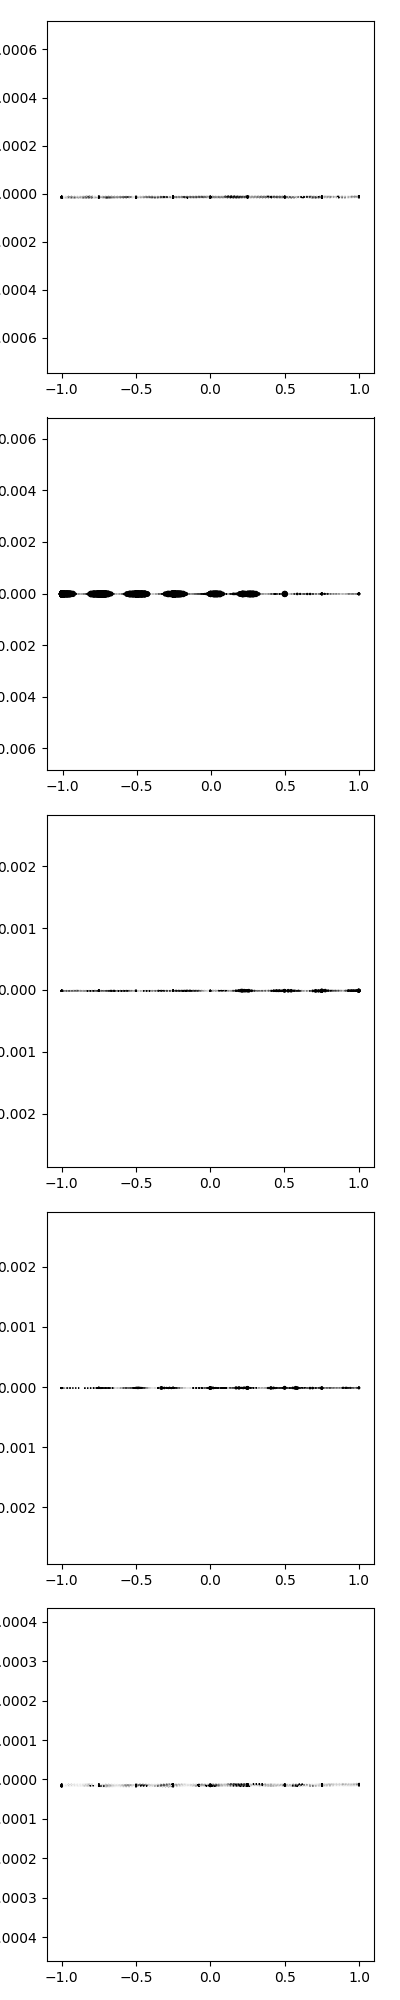

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/collections.py:865: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [134]:
test_start_t = 800
test_stop_t = test_start_t + 300
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
start, stop = test_start_i, test_stop_i # -10000, -1
start, stop = -10000, -1
step = 1
agent_hist = read_rates(outdir, 'Agent', 3, fname='history.bin')
X, Y = agent_hist[0][start:stop:step], agent_hist[1][start:stop:step]
#J = [ 7,  50,  60,
#     90, 100, 170,
#    195, 226, 283]
J = np.random.choice(np.arange(N_PLACE), 5, replace=False)
print(J)
R_PLACE = read_rates(outdir, 'PLACE', N_PLACE)[:, start:stop:step]
print(R_PLACE.shape, start, stop, rate_buf_ival)
fig, ax = plt.subplots(len(J), figsize=(4,len(J)*4))
plt.tight_layout()
ax = ax.flatten()
for i, j in enumerate(J):
    C = R_PLACE[j].copy()
    C[C<0.1] = 0
    C = 'black'
    ax[i].scatter(X, Y, 20*R_PLACE[j]/np.max(R_PLACE), C, cmap=plt.get_cmap('binary'))

<IPython.core.display.Javascript object>


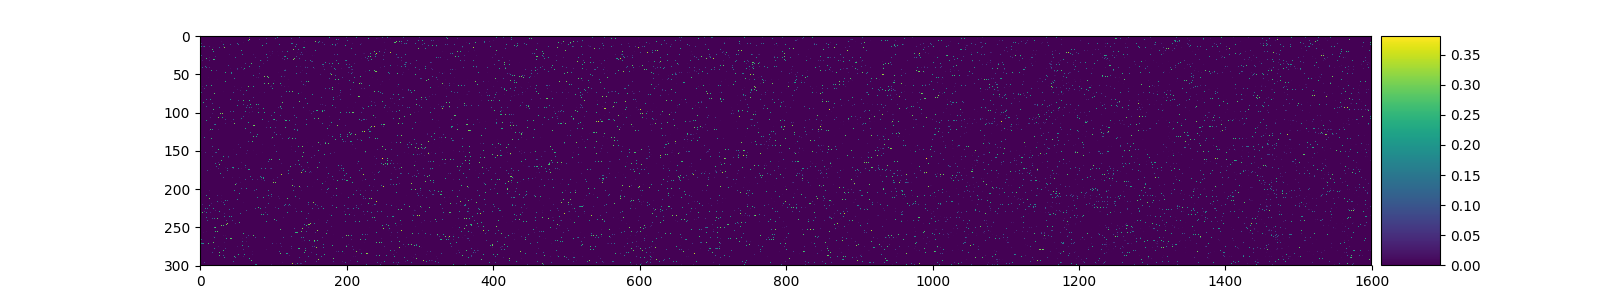

<IPython.core.display.Javascript object>


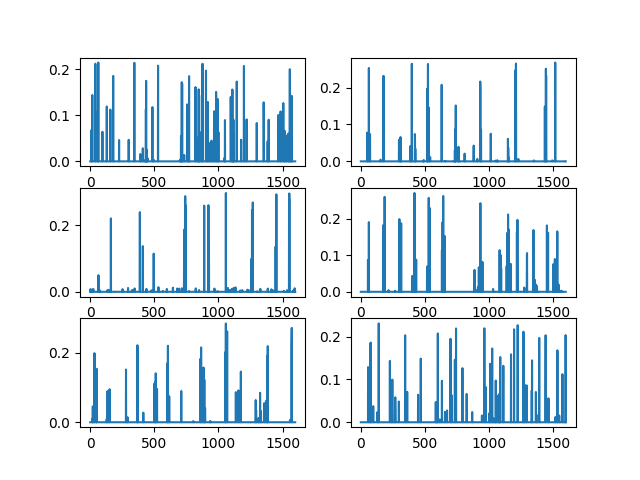

0.00335633 0.00324411
0.0753952 0.0697347


In [248]:
W_VIS_HD = read_weights(outdir, 'HD', 'VIS', N_VIS, N_HD)[-1]# - read_weights(outdir, 'HD', 'VIS', N_VIS, N_HD)[-10]
#VIS_tuning = 2 * np.pi * np.arange(N_VIS, dtype=float) / N_VIS
VIS_tuning = 2 * np.pi * np.arange((N_VIS // num_objects), dtype=float) / (N_VIS // num_objects)
VIS_tuning = np.concatenate([VIS_tuning] * num_objects)
HD_tuning = W_VIS_HD @ VIS_tuning
#W_VIS_HD_idx = np.indices((W_VIS_HD.shape[1],))[0] + 1
W_VIS_HD_idx = np.argsort(HD_tuning) # np.sum(W_VIS_HD * W_VIS_HD_idx, 1))[::-1]
W_VIS_HD_idx = np.arange(N_HD)
imshow(W_VIS_HD[W_VIS_HD_idx])
fig, ax = plt.subplots(3,2)
ax = ax.flatten()
ax[0].plot(W_VIS_HD[W_VIS_HD_idx[1]])
ax[1].plot(W_VIS_HD[10])
ax[2].plot(W_VIS_HD[150])
ax[3].plot(W_VIS_HD[200])
ax[4].plot(W_VIS_HD[W_VIS_HD_idx[-10]])
ax[5].plot(W_VIS_HD[W_VIS_HD_idx[-1]])

W_dist_HD = W_VIS_HD[:,:800]
W_prox_HD = W_VIS_HD[:,800:]
print(np.mean(W_dist_HD),
      np.mean(W_prox_HD))
print(np.mean(W_dist_HD[W_dist_HD>0]),
      np.mean(W_prox_HD[W_prox_HD>0]))

<IPython.core.display.Javascript object>


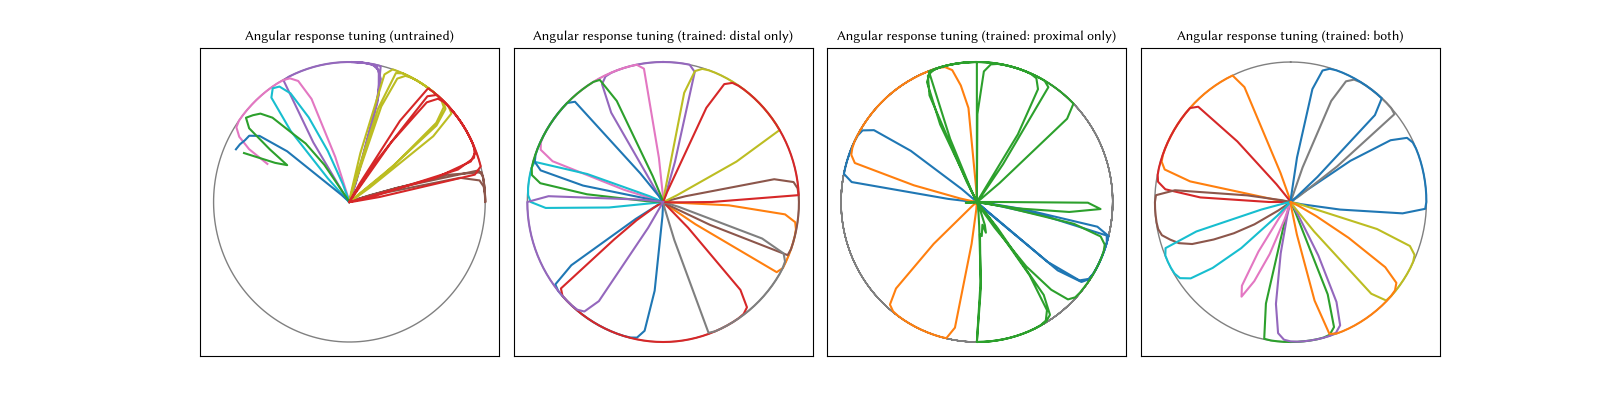

In [778]:
fig = plt.figure(figsize=(16, 4))

plt.subplots_adjust(hspace=0.05, wspace=0.05)

ax_ = plt.subplot2grid((1,4), (0,0))
ax0 = plt.subplot2grid((1,4), (0,1), sharex=ax_, sharey=ax_)
ax1 = plt.subplot2grid((1,4), (0,2), sharex=ax_, sharey=ax_)
ax2 = plt.subplot2grid((1,4), (0,3), sharex=ax_, sharey=ax_)

#Jshape = np.array((3, 3))
#J = np.random.choice(np.arange(R.shape[0]), 3, replace=False)

# Untrained:
outdir = 'pandapics/HD_VIS_out_distal_only_good_HD_20170925'

test_start_t = 1
test_stop_t = test_start_t + 2.4
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
step = 1

HD_true = read_rates(outdir, 'Agent', 3, fname='history.bin')[2, test_start_i:test_stop_i:step]
R = read_rates(outdir, 'HD', N_HD)[:, test_start_i:test_stop_i:step]
#R /= np.max(R)
R[R<0] = 0
J = [44, 51, 84, 109, 133, 184, 28, 142, 143, 213, 217, 15, 179, 183, 281]
ax_.plot(np.sin(np.linspace(0, 2*np.pi, 200)), np.cos(np.linspace(0, 2*np.pi, 200)), lw=1, color='gray')
for j in J:
    ax_.plot(R[j]*(np.sin(HD_true)), R[j]*(np.cos(HD_true)))


# Just distal:
outdir = 'pandapics/HD_VIS_out_distal_only_good_HD_20170925'

test_start_t = 1001
test_stop_t = test_start_t + 2.4
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
step = 1

HD_true = read_rates(outdir, 'Agent', 3, fname='history.bin')[2, test_start_i:test_stop_i:step]
R = read_rates(outdir, 'HD', N_HD)[:, test_start_i:test_stop_i:step]
#R /= np.max(R)
R[R<0] = 0
J = [44, 51, 84, 109, 133, 184, 28, 142, 143, 213, 217, 15, 179, 183, 281]
ax0.plot(np.sin(HD_true), np.cos(HD_true), lw=1, color='gray')
for j in J:
    ax0.plot(R[j]*(np.sin(HD_true)), R[j]*(np.cos(HD_true)))


# Just proximal:
outdir = 'pandapics/HD_VIS_out_proximal_only_poor_HD_20170925'

test_start_t = 984
test_stop_t = test_start_t + 15
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
step = 1

HD_true = read_rates(outdir, 'Agent', 3, fname='history.bin')[2, test_start_i:test_stop_i:step]
R = read_rates(outdir, 'HD', N_HD)[:, test_start_i:test_stop_i:step]
#R /= np.max(R)
R[R<0] = 0
#J = [88, 109, 214, 217, 281]
#J = [41, 44, 61, 63] #, 88, 182, 214, 267]
#J = [267]
J = [44, 63, 267]
ax1.plot(np.sin(HD_true), np.cos(HD_true), lw=1, color='gray')
for j in J:
    ax1.plot(R[j]*(np.sin(HD_true)), R[j]*(np.cos(HD_true)))


# Proximal and distal:
outdir = 'pandapics/HD_VIS_out_distal_plus_proximal_good_HD_20170925'

test_start_t = 1001
test_stop_t = test_start_t + 2.4
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
step = 1

HD_true = read_rates(outdir, 'Agent', 3, fname='history.bin')[2, test_start_i:test_stop_i:step]
R = read_rates(outdir, 'HD', N_HD)[:, test_start_i:test_stop_i:step]
#R /= np.max(R)
R[R<0] = 0
#J = np.array([13, 20, 46, 47, 51, 57, 65, 109, 136]) #, 152, 155, 156, 174, 220, 227, 238, 259, 266, 270, 270, 298])
#J = np.array([6, 13, 47, 57, 65, 109, 152, 153, 156, 207, 220, 227, 259, 266, 298])
#J = np.array([6, 13, 47, 57, 65, 109, 152, 153, 156, 207, 220, 227, 259, 266, 298])
J = np.array([13, 47, 57, 65, 109, 152, 156, 220, 227, 259, 266, 298])
#J = [227]
ax2.plot(np.sin(HD_true), np.cos(HD_true), lw=1, color='gray')
for j in J:
    ax2.plot(R[j]*(np.sin(HD_true)), R[j]*(np.cos(HD_true)))


##ax = ax.flatten()
##time = (np.arange(test_start_i, test_stop_i) - test_start_i) * rate_buf_ival
#ax.plot(np.sin(HD_true), np.cos(HD_true), lw=1, color='gray')
#for j in J:
#    ax.plot(R[j]*(np.sin(HD_true)), R[j]*(np.cos(HD_true)))

ax_.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
ax0.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
ax1.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
ax2.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/share/fonts/opentype/linux-libertine/LinBiolinum_R.otf')

ax_.set_title('Angular response tuning (untrained)', fontproperties=prop, size=14)
ax0.set_title('Angular response tuning (trained: distal only)', fontproperties=prop, size=14)
ax1.set_title('Angular response tuning (trained: proximal only)', fontproperties=prop, size=14)
ax2.set_title('Angular response tuning (trained: both)', fontproperties=prop, size=14)

fig.savefig('hd-landmarks.png', dpi=300, edgecolor='none', transparent=True)

<IPython.core.display.Javascript object>


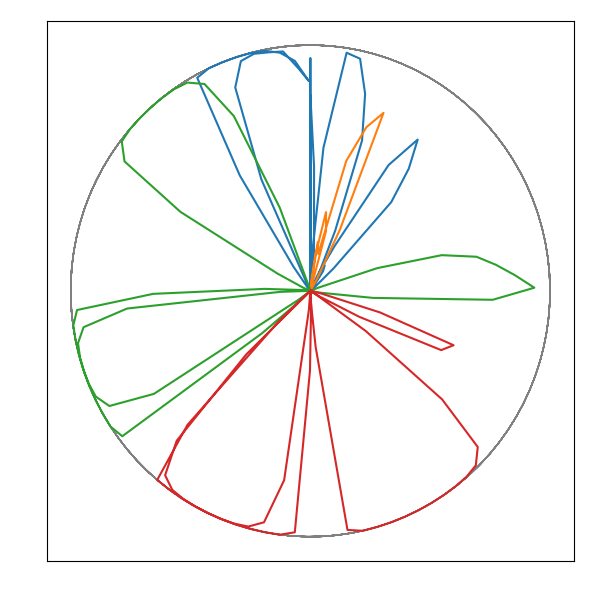

In [798]:
fig, ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
outdir = 'pandapics/PLACE_out_no_HD'

test_start_t = 1001.5
test_stop_t = test_start_t + 15
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)
step = 1

HD_true = read_rates(outdir, 'Agent', 3, fname='history.bin')[2, test_start_i:test_stop_i:step]
R = read_rates(outdir, 'PLACE', N_PLACE)[:, test_start_i:test_stop_i:step]
#R /= np.max(R)
R[R<0] = 0
J = [44, 84, 133, 184, 28, 142, 143, 213, 217, 15, 179, 183, 281]
ax.plot(np.sin(HD_true), np.cos(HD_true), lw=1, color='gray')
for j in J[:4]:
    ax.plot(R[j]*(np.sin(HD_true)), R[j]*(np.cos(HD_true)))

ax.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
fig.savefig('place-not-hd.png', dpi=300, edgecolor='none', transparent=True)

In [29]:
test_start_t = 101
test_stop_t = test_start_t + 16
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)

N_VIS_per_obj = (N_VIS // num_objects)
VIS_tuning = 2 * np.pi * np.arange(N_VIS_per_obj, dtype=float) / N_VIS_per_obj
VIS_tuning = np.concatenate([VIS_tuning] * num_objects)
VIS_in_tuning = VIS_tuning.copy()
VIS_in_tuning[(N_VIS_per_obj*distal_objects.shape[0]):] = 0

W_VIS_HD = read_weights(outdir, 'HD', 'VIS', N_VIS, N_HD)[int(test_start_t/weights_buf_ival)-1]
W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[int(test_start_t/weights_buf_ival)-1]
R_HD = read_rates(outdir, 'HD', N_HD)
R_AHVxHD = read_rates(outdir, 'AHVxHD', N_AHVxHD)
R_VIS_in = read_rates(outdir, 'VIS', N_VIS)
#R_VIS = read_rates(outdir, 'VIS_cf', N_VIS)

#HD_true = compute_HD(R_VIS, VIS_tuning)
HD_true = read_rates(outdir, 'Agent', 3, fname='history.bin')[2]
HD_in = compute_HD(R_VIS_in, VIS_in_tuning)
HD_HD = compute_HD(R_HD, VIS_tuning, W_VIS_HD)
HD_AHVxHD = compute_HD(R_AHVxHD, VIS_tuning, W_HD_AHVxHD@W_VIS_HD)

fig, ax = plt.subplots(2) #3)
ax = ax.flatten()
time = (np.arange(test_start_i, test_stop_i) - test_start_i) * rate_buf_ival
ax[0].plot(time*(np.sin(HD_true)[test_start_i:test_stop_i]),
           time*(np.cos(HD_true)[test_start_i:test_stop_i]))
#ax[0].plot(time*(np.sin(HD_in)[test_start_i:test_stop_i]),
#           time*(np.cos(HD_in)[test_start_i:test_stop_i]))
ax[0].plot(time*(np.sin(HD_HD)[test_start_i:test_stop_i]),
           time*(np.cos(HD_HD)[test_start_i:test_stop_i]))
ax[0].plot(time*(np.sin(HD_AHVxHD)[test_start_i:test_stop_i]),
           time*(np.cos(HD_AHVxHD)[test_start_i:test_stop_i]))

ax[1].plot(time+test_start_t, HD_true[test_start_i:test_stop_i], lw=3)
#ax[1].plot(time+test_start_t, HD_in[test_start_i:test_stop_i])
ax[1].plot(time+test_start_t, HD_HD[test_start_i:test_stop_i])
ax[1].plot(time+test_start_t, HD_AHVxHD[test_start_i:test_stop_i])

#min_len = np.min((len(HD_true), len(HD_HD)))
#ax[2].plot(moving_average((HD_true[test_start_i:test_stop_i]-HD_HD[test_start_i:test_stop_i])**2, 10))

print(np.mean((HD_true[test_start_i:test_stop_i]-HD_HD[test_start_i:test_stop_i])**2))
print(np.mean((HD_true[test_start_i:test_stop_i]-HD_AHVxHD[test_start_i:test_stop_i])**2))
print(np.mean((HD_HD[test_start_i:test_stop_i]-HD_AHVxHD[test_start_i:test_stop_i])**2))
#TODO: plot moving average of the error

HD_sparsity = np.mean(np.sum(R_HD[:, test_start_i:test_stop_i], 0)) / N_HD
J = np.random.choice(np.arange(N_HD), 10, replace=False) # int(N_HD*HD_sparsity)
fig, ax = plt.subplots()
for j in J:
    _theta_tmp = HD_true[test_start_i:test_stop_i]
    _r_tmp = R_HD[j, test_start_i:test_stop_i][np.argsort(_theta_tmp)]
    _theta_tmp = sorted(_theta_tmp)
    ax.plot(_r_tmp*(np.sin(_theta_tmp)),
            _r_tmp*(np.cos(_theta_tmp)), '-')

FileNotFoundError: [Errno 2] No such file or directory: 'PLACE_out/HD/weights_VIS_HD.bin'

<IPython.core.display.Javascript object>


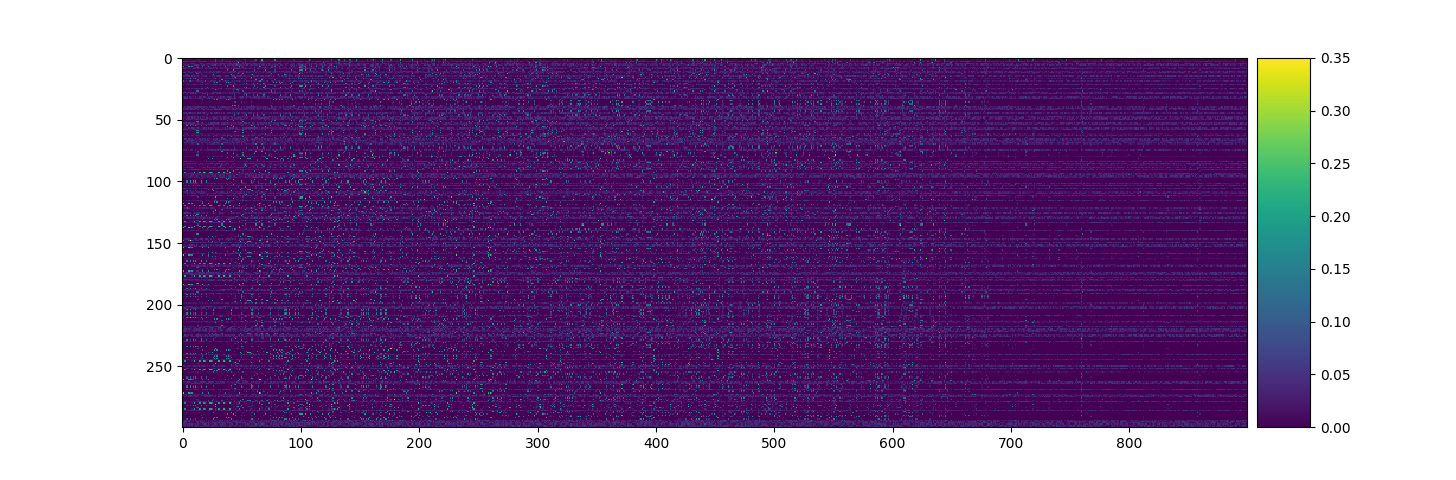

<IPython.core.display.Javascript object>


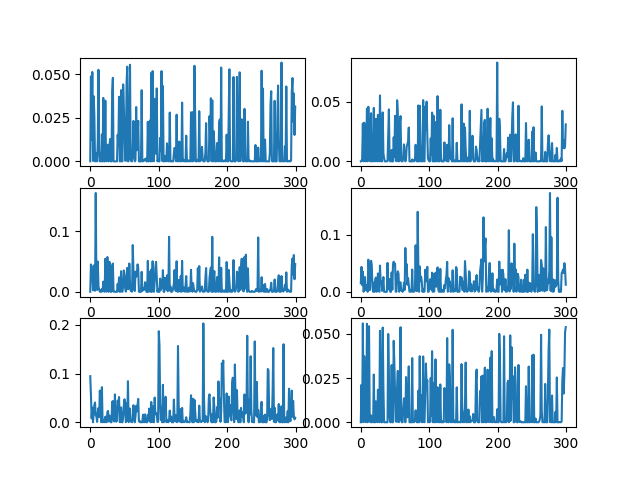

<IPython.core.display.Javascript object>


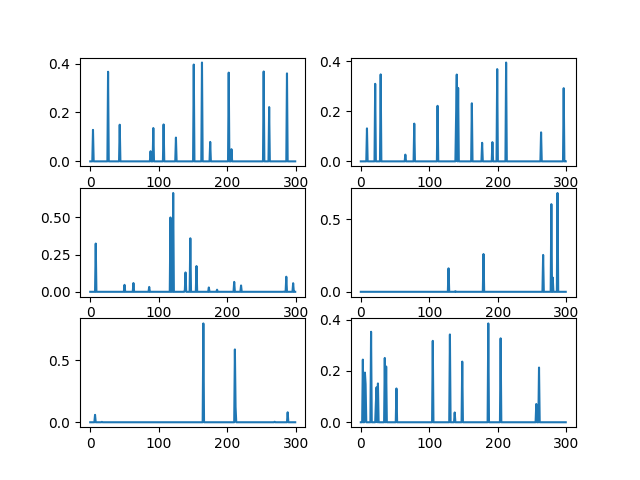

0.326892 0.999994
0.860836 0.99999


In [238]:
W_AHVxHD_HD = read_weights(outdir, 'HD', 'AHVxHD', N_AHVxHD, N_HD)[-1]
W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[-1] # - read_weights(outdir, 'AHVxHD', 'HD', 500, 1000)[0]
#W_idx = np.indices((W_AHVxHD_HD[-1].shape[0],))[0] + 1
W_idx_s = np.argsort(W_HD_AHVxHD @ HD_tuning) # np.sum(W_AHVxHD_HD[-1].T * W_idx, 1))[::-1]
W_idx_t = np.argsort(W_AHVxHD_HD @ W_HD_AHVxHD @ HD_tuning)

imshow(W_AHVxHD_HD[W_VIS_HD_idx][:, W_idx_s])# - W_AHVxHD_HD[0][:, W_idx_s])

fig, ax = plt.subplots(3,2)
ax = ax.flatten()
ax[0].plot(W_AHVxHD_HD[W_VIS_HD_idx, -10]) # .T[W_idx_s[10]]) # -W_AHVxHD_HD[0].T[W_idx_s[10]])
ax[1].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[-50]]) # .T[W_idx_s[50]]) # -W_AHVxHD_HD[0].T[W_idx_s[50]])
ax[2].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[-300]]) # .T[W_idx_s[300]]) # -W_AHVxHD_HD[0].T[W_idx_s[300]])
ax[3].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[-600]]) # .T[W_idx_s[600]]) # -W_AHVxHD_HD[0].T[W_idx_s[600]])
ax[4].plot(W_AHVxHD_HD[W_VIS_HD_idx, W_idx_s[50]]) # .T[W_idx_s[-50]]) # -W_AHVxHD_HD[0].T[W_idx_s[-50]])
ax[5].plot(W_AHVxHD_HD[W_VIS_HD_idx, 10]) # .T[W_idx_s[-10]]) # -W_AHVxHD_HD[0].T[W_idx_s[-10]])

fig, ax = plt.subplots(3,2)
ax = ax.flatten()
ax[0].plot(W_HD_AHVxHD[-10, W_VIS_HD_idx])
ax[1].plot(W_HD_AHVxHD[W_idx_s[-50], W_VIS_HD_idx])
ax[2].plot(W_HD_AHVxHD[W_idx_s[-300], W_VIS_HD_idx])
ax[3].plot(W_HD_AHVxHD[W_idx_s[-600], W_VIS_HD_idx])
ax[4].plot(W_HD_AHVxHD[W_idx_s[50], W_VIS_HD_idx])
ax[5].plot(W_HD_AHVxHD[10, W_VIS_HD_idx])

print(np.linalg.norm(W_AHVxHD_HD[:, -10]),
      np.linalg.norm(W_HD_AHVxHD[-10, :]))
print(np.linalg.norm(W_AHVxHD_HD[:, W_idx_s[1]]),
      np.linalg.norm(W_HD_AHVxHD[W_idx_s[1], :]))

#imshow(W_HD_AHVxHD)

In [542]:
W_FV_PLACExFVxHD = read_weights(outdir, 'PLACExFVxHD', 'FV', N_FV, N_PLACExFVxHD)[-1]
W_FV_PLACExFVxHD_cum = np.c_[np.sum(W_FV_PLACExFVxHD[:,:50], 1),
                             np.sum(W_FV_PLACExFVxHD[:,50:100], 1),
                         np.sum(W_FV_PLACExFVxHD[:,100:], 1)]
imshow(W_FV_PLACExFVxHD[np.argsort(W_FV_PLACExFVxHD_cum@np.array([25,75,125]))])
print(np.linalg.norm(W_FV_PLACExFVxHD[10]))
print(np.sum(W_FV_PLACExFVxHD[:,:50])/np.sum(W_FV_PLACExFVxHD),
      np.sum(W_FV_PLACExFVxHD[:,50:100])/np.sum(W_FV_PLACExFVxHD),
      np.sum(W_FV_PLACExFVxHD[:,100:])/np.sum(W_FV_PLACExFVxHD))

FileNotFoundError: [Errno 2] No such file or directory: 'pandapics/PLACE_Qpolicy_proximal/PLACExFVxHD/weights_FV_PLACExFVxHD.bin'

In [1201]:
W_VIS_HD = read_weights(outdir, 'HD', 'VIS', N_VIS, N_HD)[-1]
#W_VIS_HD[W_VIS_HD_idx] += np.fliplr(np.identity(N_HD) * 0.5)
W_VIS_HD.tofile('VIS/W_VIS_HD.bin')

W_AHVxHD_HD = read_weights(outdir, 'HD', 'AHVxHD', N_AHVxHD, N_HD)[-1]
#W_AHVxHD_HD = np.random.random(W_AHVxHD_HD.shape).astype(np.float32)
#W_AHVxHD_HD = scipy.sparse.rand(W_AHVxHD_HD.shape[0], W_AHVxHD_HD.shape[1], 0.4, dtype=np.float32).todense()
##N_REPLACE = 80
##W_tmp = W_AHVxHD_HD.copy()
##W_tmp[:, W_idx_s[-N_REPLACE:]] = (1+np.random.random((500, N_REPLACE)))/100
##W_tmp.tofile('W_AHVxHD_HD.bin')
W_AHVxHD_HD.tofile('VIS/W_AHVxHD_HD.bin')

W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[-1]
#W_HD_AHVxHD = scipy.sparse.rand(W_HD_AHVxHD.shape[0], W_HD_AHVxHD.shape[1], 0.05, dtype=np.float32).todense()
##W_tmp = W_HD_AHVxHD.copy()
##W_tmp__ = W_HD_AHVxHD.copy()
##W_tmp[W_idx_s[-N_REPLACE:], :][W_tmp[W_idx_s[-N_REPLACE:], :] > 0] = 0.1
W_HD_AHVxHD.tofile('VIS/W_HD_AHVxHD.bin')

W_AHV_AHVxHD = read_weights(outdir, 'AHVxHD', 'AHV', N_AHV, N_AHVxHD)[-1]
W_AHV_AHVxHD.tofile('VIS/W_AHV_AHVxHD.bin')

#imshow(W_HD_AHVxHD)

In [924]:
plt.close('all')

<IPython.core.display.Javascript object>


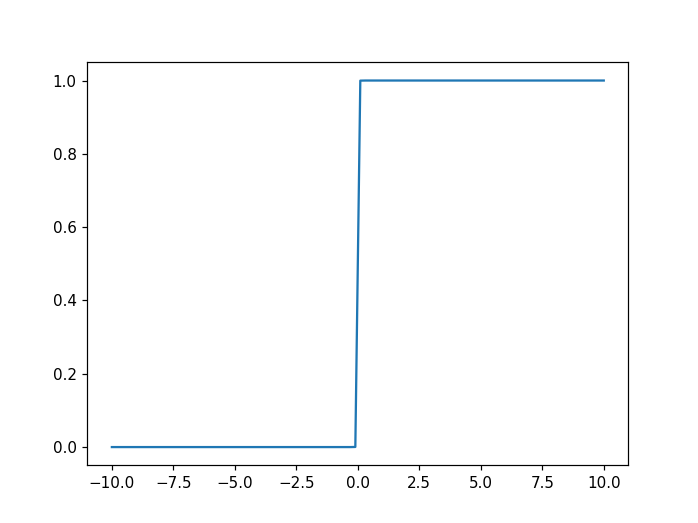

In [1495]:
fig, ax = plt.subplots()
X = np.linspace(-10, 10, 100)
ax.plot(X, 0.5*(np.tanh(40*X)+1))